In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import logistic
from scipy.special import logit

import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt


# own utils
from utils.graph import *
from utils.tram_models import *
from utils.tram_model_helpers import *
from utils.tram_data import *
from utils.continous import *
from utils.sampling_tram_data import *

import os
import sys
from datetime import datetime

import ipywidgets as widgets
from IPython.display import display, clear_output


Train with GPU support.


In [ ]:
def new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR):
    """
    creates the empty_configuration_file for the experiment
    
    Structure:
    
    json / dictionary like
    
    {
        date_of_creation: '1.1.2024'
        experiment_name: "example_1"
        PATHS:{
                    DATA_PATH:
                    LOG_DIR:
                    EXPERIMENT_DIR:
                }  
        data_type: {'x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont','x6':'cont','x7':'cont','x8':'cont'},  # continous , images , ordinal
        adj_matrix:   [[0,cs],[0,0]],
        model_names:  [[0,ComplexInterceptDefaultTabular],[0,0]],
        
        seed:42, 
        
        nodes: {'x1': { 'Modelnr': 0,
                        'data_type': 'cont',
                        'node_type': 'source',
                        'parents': [],
                        'parents_datatype': {},
                        'transformation_terms_in_h()': {},
                        'transformation_term_nn_models_in_h()': {},
                        'min': 0.1023280003906143,
                        'max': 1.895380529733125},
                'x2': { 'Modelnr': 1,
                        'data_type': 'cont',
                        'node_type': 'sink',
                        'parents': ['x1'],
                        'parents_datatype': {},
                        'transformation_terms_in_h()': {'x1':'cs'},
                        'transformation_term_nn_models_in_h()': {'x1':'ComplexInterceptDefaultTabular'},
                        'min': 0.09848326169895154,
                        'max': 1.9048444463462053},
                }
    
    """
    configuration_dict=    {
                            'date_of_creation':          None,
                            'experiment_name' :          None,
                            'PATHS':{
                                    'DATA_PATH':         None,
                                    'LOG_DIR':           None,
                                    'EXPERIMENT_DIR':    None,
                                    }, 
                            'data_type':                 None,
                            'adj_matrix':                None,
                            'model_names':               None,
                            'seed':                      None, 
                            'nodes':                     None,
                            }
    
    configuration_dict['date_of_creation']=datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    configuration_dict['experiment_name']=experiment_name
    configuration_dict['PATHS']['DATA_PATH']=DATA_PATH
    configuration_dict['PATHS']['LOG_DIR']=LOG_DIR
    configuration_dict['PATHS']['EXPERIMENT_DIR']=EXPERIMENT_DIR
    
    return configuration_dict


def write_configuration_dict(configuration_dict, CONF_DICT_PATH):
    """
    Write out the configuration dict as JSON. 
    Catches filesystem and serialization errors.
    """
    try:
        with open(CONF_DICT_PATH, 'w', encoding='utf-8') as f:
            json.dump(configuration_dict, f, indent=4)
    except (OSError, TypeError) as e:
        # OSError covers file I/O errors, TypeError covers JSON serialization issues
        print(f"Error writing config to {CONF_DICT_PATH}: {e}", file=sys.stderr)
        raise   

def load_configuration_dict(CONF_DICT_PATH):
    """
    Load configuration dictionary from a JSON file.

    :param CONF_DICT_PATH: Path to the JSON configuration file.
    :return: The configuration dictionary.
    :raises:
        OSError if the file can’t be read,
        json.JSONDecodeError if the file isn’t valid JSON.
    """
    try:
        with open(CONF_DICT_PATH, 'r', encoding='utf-8') as f:
            config = json.load(f)
        return config
    except (OSError, json.JSONDecodeError) as e:
        print(f"Error loading config from {CONF_DICT_PATH}: {e}", file=sys.stderr)
        raise

def create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR):
    
    """
    Create a new configuration dictionary for the experiment and write it to the specified path.
    :param experiment_name: Name of the experiment.
    :param CONF_DICT_PATH: Path where the configuration dictionary should be saved.
    :param EXPERIMENT_DIR: Directory for the experiment.
    :param DATA_PATH: Path to the data.
    :param LOG_DIR: Directory for logs.
    :return: The created configuration dictionary.
    :raises:
        OSError if the file can’t be written,
        json.JSONDecodeError if the file isn’t valid JSON.
        Exception if there is an error creating the configuration dictionary.
    """
    try:
        configuration_dict=new_conf_dict(experiment_name,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    except:
        print(f"Error creating configuration dictionary for {experiment_name}.", file=sys.stderr)
        raise
    try:
        write_configuration_dict(configuration_dict, CONF_DICT_PATH)
    except:
        print(f"Error writing configuration dictionary to {CONF_DICT_PATH}.", file=sys.stderr)
        raise
    return configuration_dict

def read_adj_matrix_from_configuration(CONF_DICT_PATH):
    """
    Read the adjacency matrix from the configuration dictionary.
    
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    :return: The adjacency matrix as a numpy array.
    """
    configuration_dict = load_configuration_dict(CONF_DICT_PATH)
    if configuration_dict['adj_matrix'] is None:
        return None
    else:
        adj_matrix = configuration_dict['adj_matrix']
        if isinstance(adj_matrix, list):
            adj_matrix = np.array(configuration_dict['adj_matrix'])
        return adj_matrix

def write_adj_matrix_to_configuration(adj_matrix, CONF_DICT_PATH):
    """
    Write the adjacency matrix to the configuration dictionary.
    
    :param adj_matrix: The adjacency matrix to write.
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    """
    configuration_dict = load_configuration_dict(CONF_DICT_PATH)
    configuration_dict['adj_matrix'] = adj_matrix.tolist()  # Convert to list for JSON serialization
    write_configuration_dict(configuration_dict, CONF_DICT_PATH)


def write_data_type_to_configuration(data_type:dict, CONF_DICT_PATH):
    """
    Write the data type information to the configuration dictionary.
    
    :param data_type: Dictionary containing variable names and their data types.
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    """
    configuration_dict = load_configuration_dict(CONF_DICT_PATH)
    configuration_dict['data_type'] = data_type
    write_configuration_dict(configuration_dict, CONF_DICT_PATH)

def read_nn_names_matrix_from_configuration(CONF_DICT_PATH):
    """
    Read the neural network names matrix from the configuration dictionary.
    
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    :return: The neural network names matrix as a numpy array.
    """
    configuration_dict = load_configuration_dict(CONF_DICT_PATH)
    if configuration_dict['model_names'] is None:
        return None
    else:
        nn_names_matrix = configuration_dict['model_names']
        if isinstance(nn_names_matrix, list):
            nn_names_matrix = np.array(configuration_dict['model_names'])
        return nn_names_matrix
    
def write_nn_names_matrix_to_configuration(nn_names_matrix, CONF_DICT_PATH):
    """
    Write the neural network names matrix to the configuration dictionary.
    
    :param nn_names_matrix: The neural network names matrix to write.
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    """
    configuration_dict = load_configuration_dict(CONF_DICT_PATH)
    configuration_dict['model_names'] = nn_names_matrix.tolist()  # Convert to list for JSON serialization
    write_configuration_dict(configuration_dict, CONF_DICT_PATH)
    
    
    
def interactive_adj_matrix(CONF_DICT_PATH ,seed=5):
    
    data_type =  load_configuration_dict(CONF_DICT_PATH)['data_type']
    n = len(data_type.keys())
    adj_matrix=read_adj_matrix_from_configuration(CONF_DICT_PATH)
    
    if adj_matrix is not None:
        plot_dag(adj_matrix, data_type, seed=seed)
        return None
        
    else:
        print("No matrix found. Please fill out the DAG and click 'Generate'.")

        output = widgets.Output()
        cells = {}

        def create_grid():
            input_grid = []
            header_widgets = [widgets.Label(value='')] + [widgets.Label(value=name) for name in data_type.keys()]
            input_grid.extend(header_widgets)

            for i in range(n):
                input_grid.append(widgets.Label(value=data_type.keys()[i]))
                for j in range(n):
                    if i >= j:
                        cell = widgets.Label(value="0")
                    else:
                        cell = widgets.Text(value="", placeholder="e.g., ls", layout=widgets.Layout(width='70px'))
                    cells[(i, j)] = cell
                    input_grid.append(cell)

            return widgets.GridBox(
                children=input_grid,
                layout=widgets.Layout(
                    grid_template_columns=("80px " * (n + 1)).strip(),
                    overflow='auto'
                )
            )

        def on_generate_clicked(b):
            with output:
                clear_output()
                adj_matrix = np.empty((n, n), dtype=object)
                for i in range(n):
                    for j in range(n):
                        if i >= j:
                            adj_matrix[i, j] = "0"
                        else:
                            adj_matrix[i, j] = cells[(i, j)].value.strip() or "0"

                try:
                    if not validate_adj_matrix(adj_matrix):
                        raise ValueError("Invalid adjacency matrix. Please check the criteria.")
                    write_adj_matrix_to_configuration(adj_matrix, CONF_DICT_PATH)
                    plot_dag(adj_matrix, data_type, seed=seed)
                    return None
                except Exception as e:
                    print(f"Error saving or plotting DAG: {e}")

        generate_btn = widgets.Button(description="Generate Matrix + Plot DAG", button_style='success')
        generate_btn.on_click(on_generate_clicked)

        gridbox = create_grid()
        ui = widgets.VBox([
            widgets.Label("Fill in the adjacency matrix (upper triangle only). Use 'ls', 'cs', etc."),
            gridbox,
            generate_btn,
            output
        ])

        display(ui)
        return None


def interactive_nn_names_matrix(CONF_DICT_PATH, seed=5):
    """
    If a saved NN-names matrix exists in configuration, load & display it.
    Otherwise, generate defaults from the adjacency matrix, show them
    in an editable grid (only for non-zero entries), and let the user overwrite before saving & plotting.
    """
    # Load config, types, matrices
    cfg = load_configuration_dict(CONF_DICT_PATH)
    data_type = cfg['data_type']
    adj_matrix = read_adj_matrix_from_configuration(CONF_DICT_PATH)
    nn_names_matrix = read_nn_names_matrix_from_configuration(CONF_DICT_PATH)
    var_names = list(data_type.keys())
    n = len(var_names)

    # If already saved, just plot and exit
    if nn_names_matrix is not None:
        plot_nn_names_matrix(nn_names_matrix, data_type)
        return

    # No saved NN-names → build defaults
    default_nn = create_nn_model_names(adj_matrix, data_type)

    output = widgets.Output()
    cells = {}

    def create_grid():
        # Build header row
        header_widgets = [widgets.Label(value="")] + [widgets.Label(value=v) for v in var_names]
        grid = header_widgets.copy()

        for i, vi in enumerate(var_names):
            grid.append(widgets.Label(value=vi))
            for j, vj in enumerate(var_names):
                if i >= j:
                    # Diagonal & lower triangle: non-editable blank
                    cell = widgets.Label(value="")
                else:
                    default = default_nn[i, j]
                    if default == "0":
                        # Do not display zeros
                        cell = widgets.Label(value="")
                    else:
                        # Editable for prefilled entries only
                        cell = widgets.Text(
                            value=default,
                            placeholder="",
                            layout=widgets.Layout(width="100px")
                        )
                        cells[(i, j)] = cell
                grid.append(cell)

        return widgets.GridBox(
            children=grid,
            layout=widgets.Layout(
                grid_template_columns=("100px " * (n + 1)).strip(),
                overflow="auto"
            )
        )

    def on_generate_clicked(b):
        with output:
            clear_output()
            # Build final nn_names_matrix
            nm = np.empty((n, n), dtype=object)
            for i in range(n):
                for j in range(n):
                    if i >= j:
                        nm[i, j] = "0"
                    else:
                        if (i, j) in cells:
                            val = cells[(i, j)].value.strip()
                            nm[i, j] = val if val else default_nn[i, j]
                        else:
                            nm[i, j] = "0"
            try:
                write_nn_names_matrix_to_configuration(nm, CONF_DICT_PATH)
                plot_nn_names_matrix(nm, data_type)
            except Exception as e:
                print(f"Error saving or plotting NN-names matrix: {e}")

    # Button to save and plot
    btn = widgets.Button(description="Generate NN-Names + Plot", button_style="success")
    btn.on_click(on_generate_clicked)

    # Layout UI
    grid = create_grid()
    ui = widgets.VBox([
        widgets.Label("Edit only the existing model names (non-zero entries)."),
        grid,
        btn,
        output
    ])
    display(ui)



def get_nodes_dict(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals):
    """
    Creates a configuration dictionary for TRAMADAG based on an adjacency matrix,
    a neural network names matrix, and a data type dictionary.
    """
    if not validate_adj_matrix(adj_matrix):
        raise ValueError("Invalid adjacency matrix. Please check the criteria.")
    
    if len(data_type) != adj_matrix.shape[0]:
        raise ValueError("Data type dictionary should have the same length as the adjacency matrix.")
    
    nodes_dict = {}
    G, edge_labels = create_nx_graph(adj_matrix, node_labels=list(data_type.keys()))
    
    sources = [node for node in G.nodes if G.in_degree(node) == 0]
    sinks = [node for node in G.nodes if G.out_degree(node) == 0]
    
    for i, node in enumerate(G.nodes):
        parents = list(G.predecessors(node))
        nodes_dict[node] = {}
        nodes_dict[node]['Modelnr'] = i
        nodes_dict[node]['data_type'] = data_type[node]
        nodes_dict[node]['node_type'] = "source" if node in sources else "sink" if node in sinks else "internal"
        nodes_dict[node]['parents'] = parents
        nodes_dict[node]['parents_datatype'] = {parent:data_type[parent] for parent in parents}
        nodes_dict[node]['transformation_terms_in_h()'] = {parent: edge_labels[(parent, node)] for parent in parents if (parent, node) in edge_labels}
        nodes_dict[node]['min']=min_vals[i].tolist()   
        nodes_dict[node]['max']=max_vals[i].tolist()
        
        transformation_term_nn_models = {}
        for parent in parents:
            parent_idx = list(data_type.keys()).index(parent)  
            child_idx = list(data_type.keys()).index(node) 
            
            if nn_names_matrix[parent_idx, child_idx] != "0":
                transformation_term_nn_models[parent] = nn_names_matrix[parent_idx, child_idx]
        nodes_dict[node]['transformation_term_nn_models_in_h()'] = transformation_term_nn_models
    return nodes_dict


def write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals):  
    """
    Write the nodes information to the configuration dictionary.
    
    :param CONF_DICT_PATH: Path to the configuration dictionary.
    """
    adj_matrix = read_adj_matrix_from_configuration(CONF_DICT_PATH)
    nn_names_matrix = read_nn_names_matrix_from_configuration(CONF_DICT_PATH)
    data_type = load_configuration_dict(CONF_DICT_PATH)['data_type']
    
    configuration_dict = get_nodes_dict(adj_matrix, nn_names_matrix, data_type, min_vals, max_vals)
    
    conf = load_configuration_dict(CONF_DICT_PATH)
    conf['nodes'] = configuration_dict
    write_configuration_dict(conf, CONF_DICT_PATH)
    

# 1. Experiments and Paths

In [ ]:
experiment_name = "conf_dict"   ## <--- set experiment name
seed=42
np.random.seed(seed)

LOG_DIR="/home/bule/TramDag/dev_experiment_logs"
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
DATA_PATH = EXPERIMENT_DIR # <----------- change to different source if needed
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

os.makedirs(EXPERIMENT_DIR,exist_ok=True)
# check if configration dict already exists if not create:

if os.path.exists(CONF_DICT_PATH):
    configuration_dict=load_configuration_dict(CONF_DICT_PATH)
    print(f"Loaded existing configuration from {CONF_DICT_PATH}")
else:
    configuration_dict=create_and_write_new_configuration_dict(experiment_name,CONF_DICT_PATH,EXPERIMENT_DIR,DATA_PATH,LOG_DIR)
    print(f"Created new configuration file at {CONF_DICT_PATH}")

Loaded existing configuration from /home/bule/TramDag/dev_experiment_logs/conf_dict/configuration.json


# 2.  Data

In [4]:
from scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D


# Define the functions used in the DGP
def f1(x1, x2):
    return np.sin(np.pi * x1) * np.cos(np.pi * x2)

def f2(x3, x4):
    return np.exp(-((x3 - 1)**2 + (x4 - 1)**2))

def f3(x5, x6):
    return (x5 * x6) / (1 + x5**2 + x6**2)

def dgp_continuous_interactions(n_obs=10_000, seed=42):
    np.random.seed(seed)

    # Independent variables
    x1 = np.random.uniform(0, 2, size=n_obs)
    x2 = np.random.uniform(0, 2, size=n_obs)
    x3 = np.random.uniform(0, 2, size=n_obs)
    x4 = np.random.uniform(0, 2, size=n_obs)
    x5 = np.random.normal(0, 2, size=n_obs)
    x6 = np.random.uniform(0, 2, size=n_obs)
    x7 = np.random.normal(0, 2, size=n_obs)

    # Response variable with interactions
    y = f1(x1, x2) + f2(x3, x4) + f3(x5, x6) + 1.5 * x7

    df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'x5': x5, 'x6': x6, 'x7': x7, 'x8': y})
    return df


EXP_DATA_PATH=os.path.join(DATA_PATH, f"{experiment_name}.csv")
if not os.path.exists(EXP_DATA_PATH):
    df = dgp_continuous_interactions()

    print(df.head())
    df.to_csv(EXP_DATA_PATH, index=False)
else:
    df = pd.read_csv(EXP_DATA_PATH)
    print(f"Loaded data from {EXP_DATA_PATH}")


data_type= {'x1':'cont','x2':'cont','x3':'cont','x4':'cont','x5':'cont','x6':'cont','x7':'cont','x8':'cont'} # cont:continous, ord:ordinal, oher:everything else than images

write_data_type_to_configuration(data_type, CONF_DICT_PATH)


Loaded data from /home/bule/TramDag/dev_experiment_logs/conf_dict/conf_dict.csv


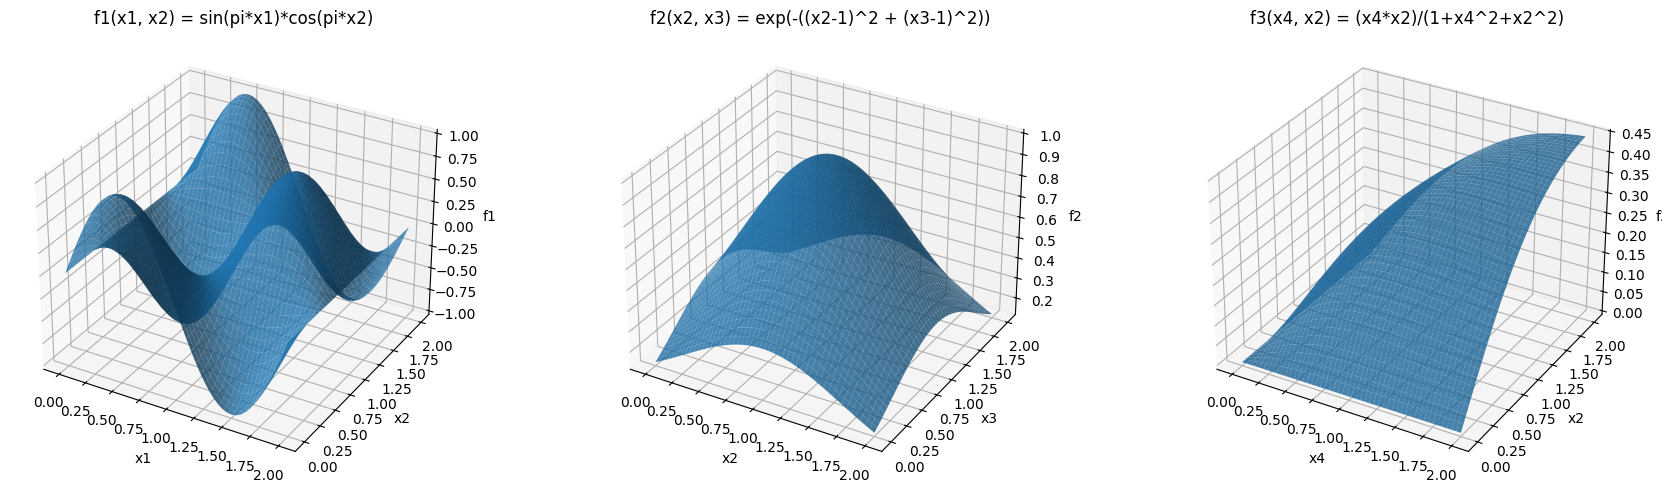

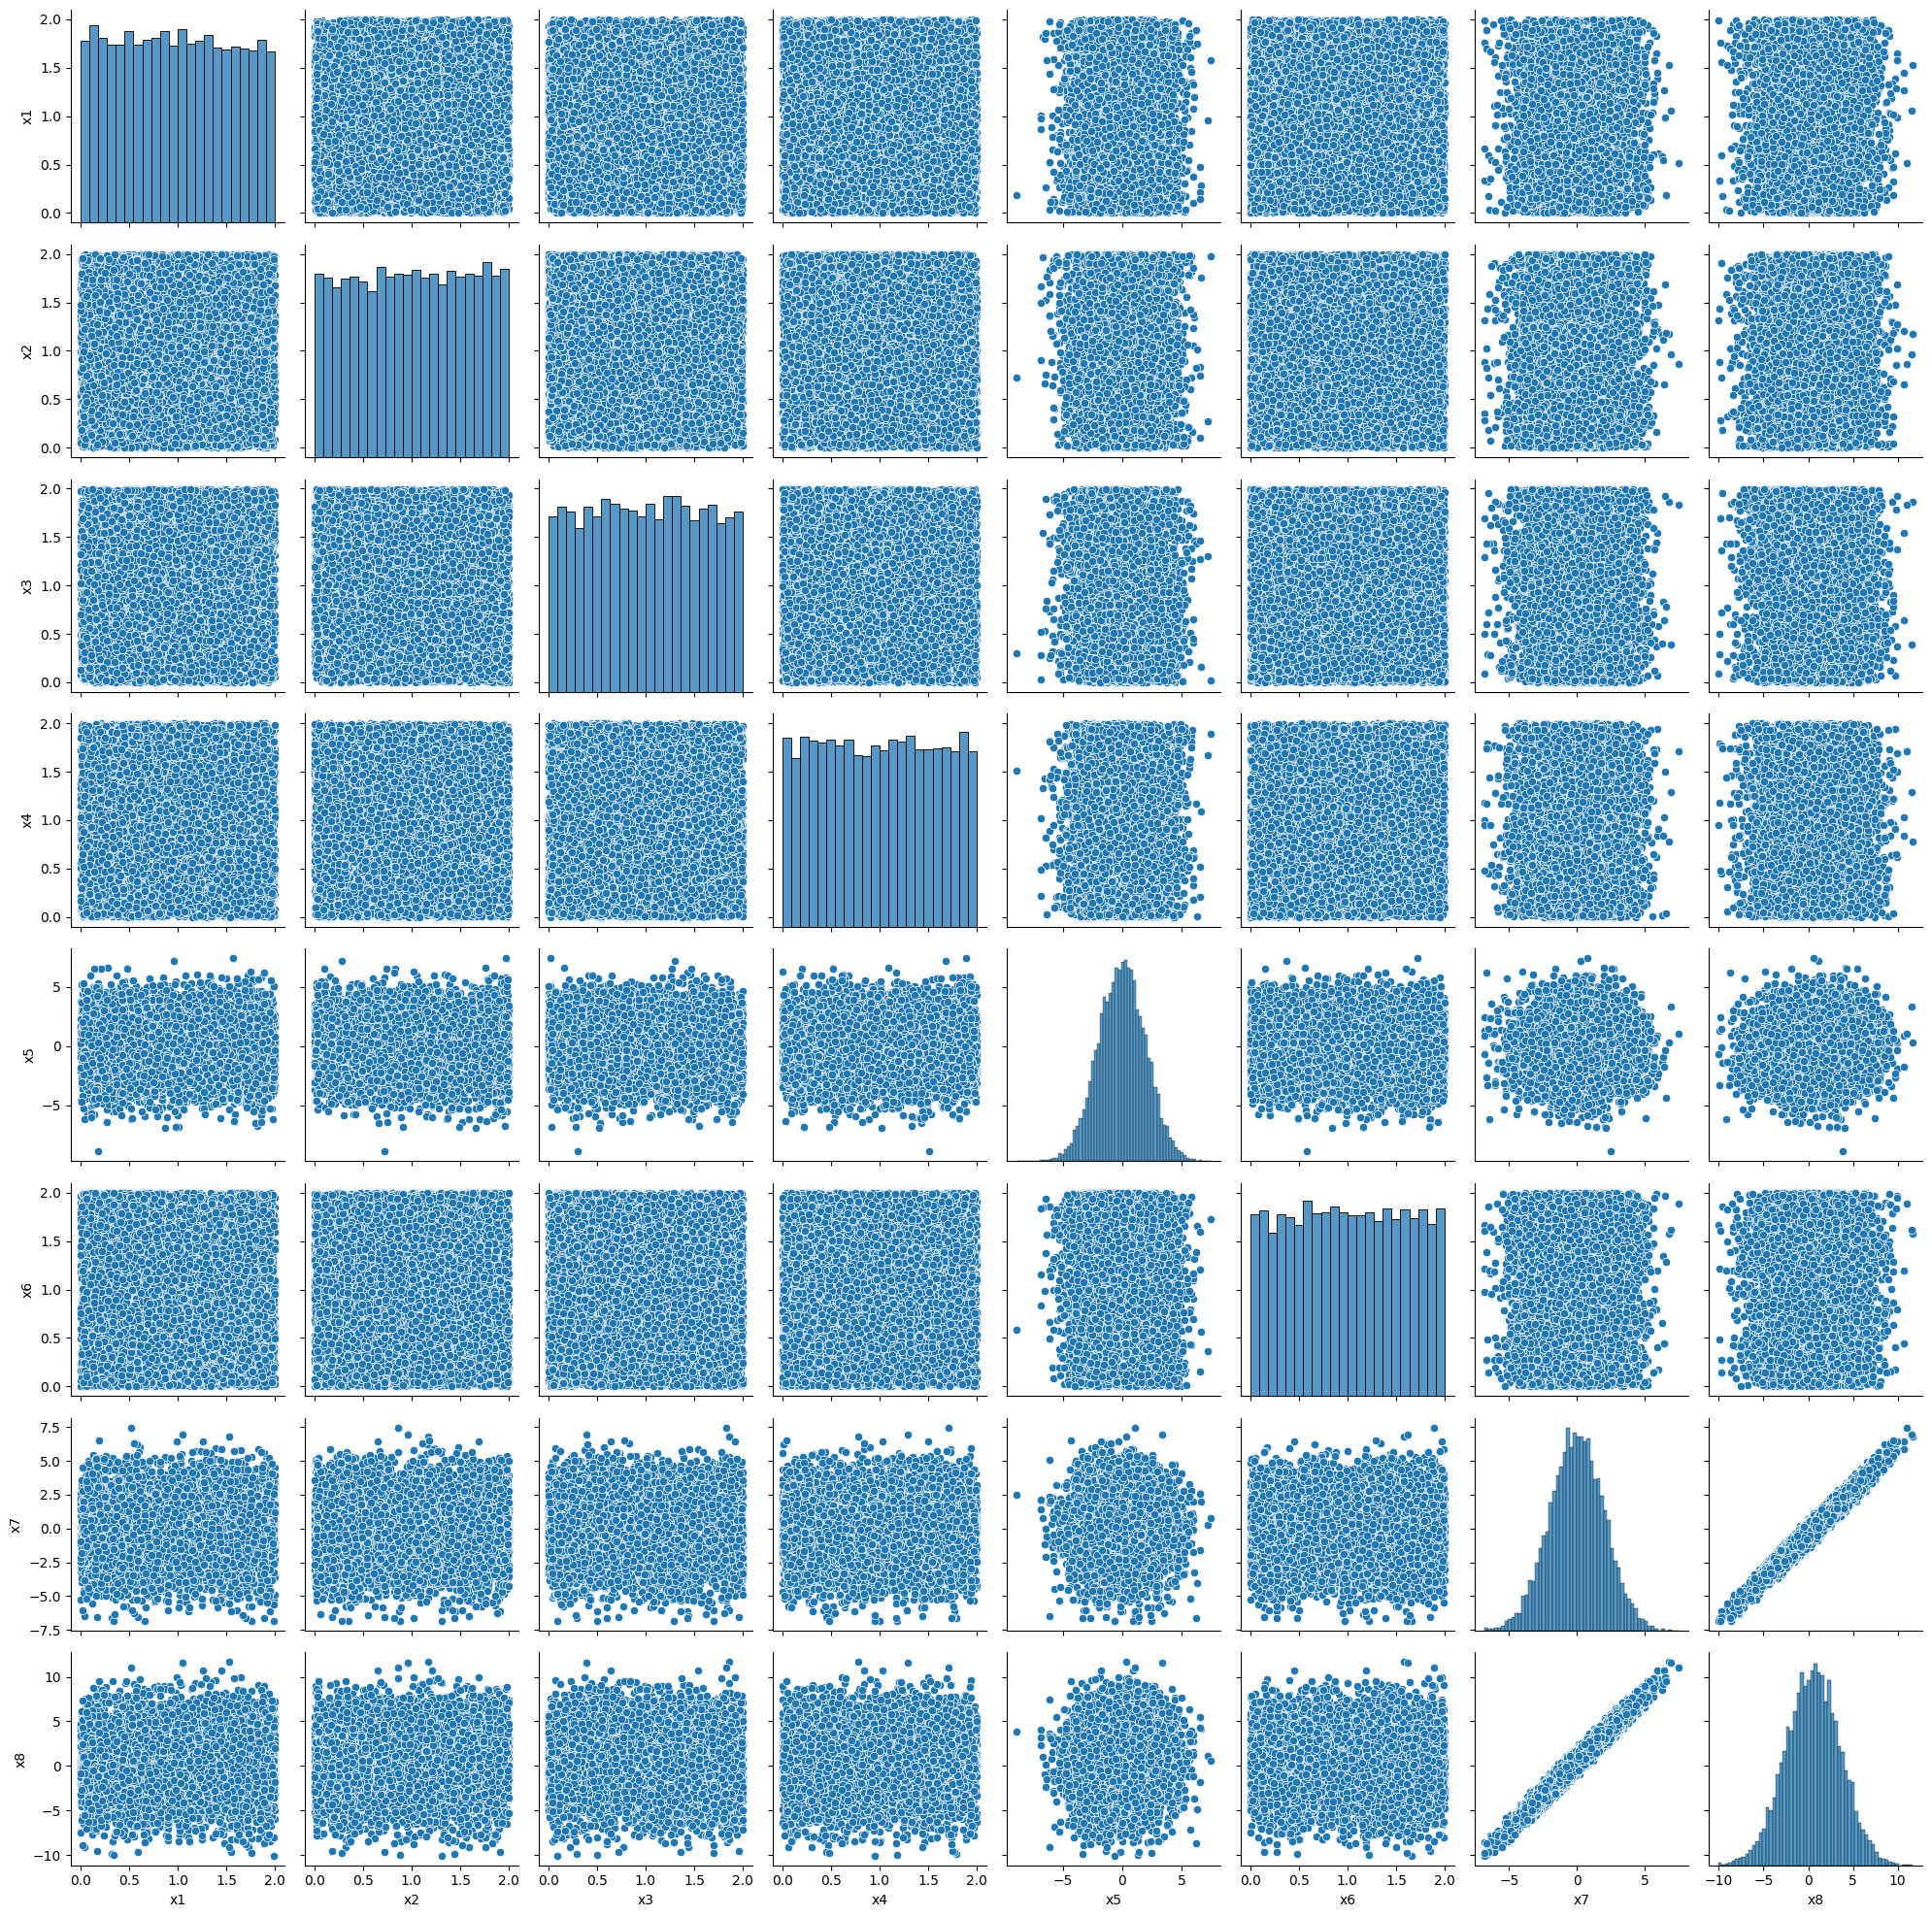

In [5]:

# Visualize the 3 interaction functions
fig = plt.figure(figsize=(18, 5))

# f1(x1, x2)
ax = fig.add_subplot(131, projection='3d')
x = np.linspace(0, 2, 50)
y = np.linspace(0, 2, 50)
X, Y = np.meshgrid(x, y)
Z = f1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f1(x1, x2) = sin(pi*x1)*cos(pi*x2)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("f1")

# f2(x2, x3)
ax = fig.add_subplot(132, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f2(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f2(x2, x3) = exp(-((x2-1)^2 + (x3-1)^2))")
ax.set_xlabel("x2")
ax.set_ylabel("x3")
ax.set_zlabel("f2")

# f3(x4, x2)
ax = fig.add_subplot(133, projection='3d')
X, Y = np.meshgrid(x, y)
Z = f3(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.8)
ax.set_title("f3(x4, x2) = (x4*x2)/(1+x4^2+x2^2)")
ax.set_xlabel("x4")
ax.set_ylabel("x2")
ax.set_zlabel("f3")

plt.tight_layout()
plt.show()


sns.pairplot(df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

## 2.1 train test split

In [6]:
# 1. Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 2. Compute quantiles from training data
quantiles = train_df.quantile([0.05, 0.95])
min_vals = quantiles.loc[0.05]
max_vals = quantiles.loc[0.95]

# 3. Normalize all sets using training quantiles
def normalize_with_quantiles(df, min_vals, max_vals):
    return (df - min_vals) / (max_vals - min_vals)

# train_df = normalize_with_quantiles(train_df, min_vals, max_vals)
# val_df = normalize_with_quantiles(val_df, min_vals, max_vals)
# test_df = normalize_with_quantiles(test_df, min_vals, max_vals)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 8000, Validation size: 1000, Test size: 1000


# 3. Define graph Structure

- define graph and which shift and intercept terms to use


/home/bule/TramDag/utils/graph.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


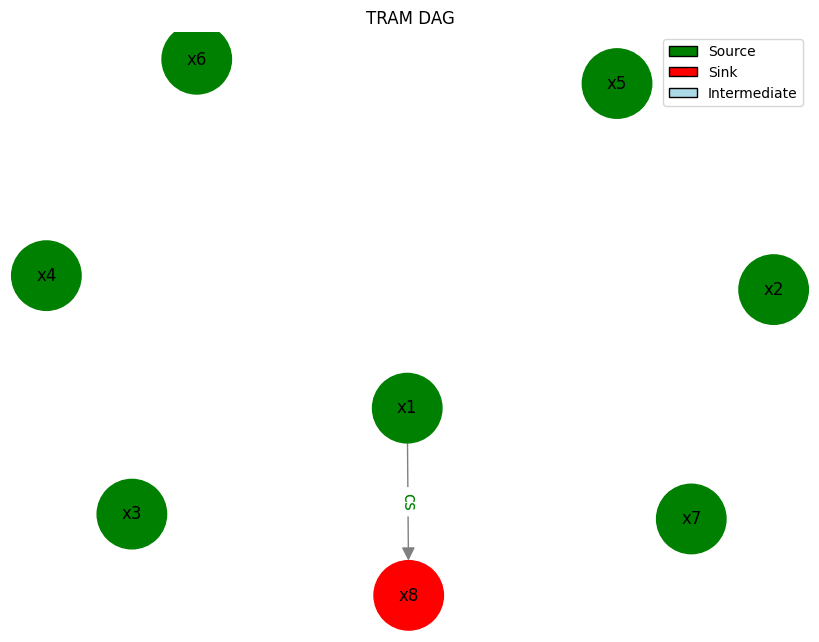

In [7]:
interactive_adj_matrix(CONF_DICT_PATH,seed )

# 4. Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

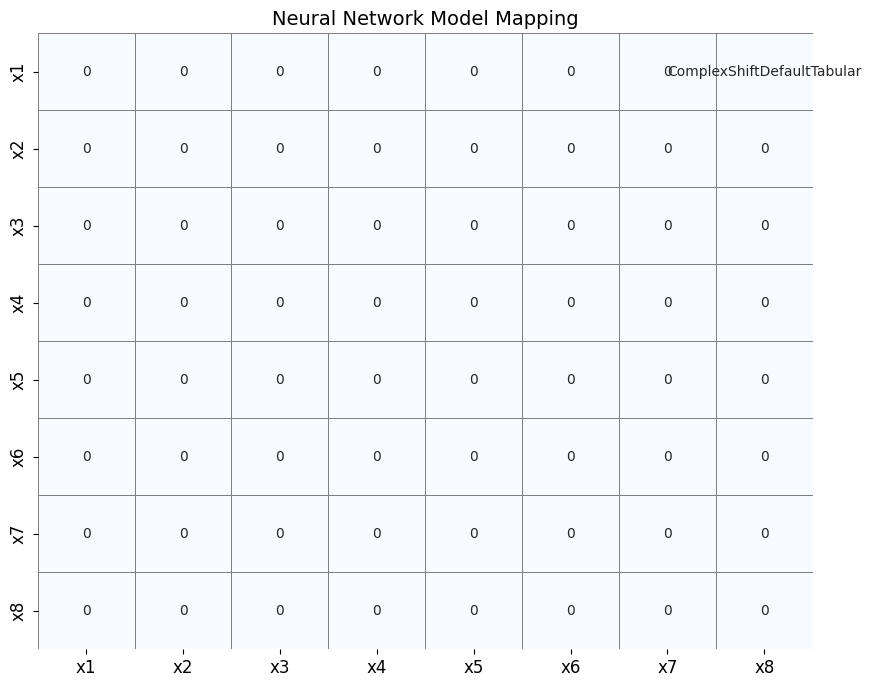

In [8]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [9]:
write_nodes_information_to_configuration(CONF_DICT_PATH, min_vals, max_vals)

/tmp/ipykernel_1977393/189401114.py:407: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['min']=min_vals[i].tolist()
/tmp/ipykernel_1977393/189401114.py:408: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nodes_dict[node]['max']=max_vals[i].tolist()


In [10]:
# read configuration dict
configuration_dict = load_configuration_dict(CONF_DICT_PATH)

In [ ]:
DEV_TRAINING=True
train_list=['x1','x2','x3','x4','x5','x6','x7','x8']#['x2']#'x1','x2']#,'x3']#['x1']#['x1','x2','x3']#,#,['x1','x2','x3'] # <-  set the nodes which have to be trained , useful if further training is required else lsit all vars

batch_size = 512#4112
epochs = 200# <- if you want a higher numbe rof epochs, set the number higher and it loads the old model and starts from there
learning_rate=0.01
use_scheduler =  False

In [ ]:
# For each NODE 
target_nodes = configuration_dict['nodes']

for node in target_nodes:
    
    print(f'\n----*----------*-------------*--------------- Node: {node} ------------*-----------------*-------------------*--')
    ########################## 0. Skip nodes ###############################
    if node not in train_list:# Skip if node is not in train_list
        print(f"Skipping node {node} as it's not in the training list.")
        continue
    if (target_nodes[node]['node_type'] == 'source') and (target_nodes[node]['node_type'] == 'other'):# Skip unsupported types
        print(f"Node type : other , is not supported yet")
        continue

    ########################## 1. Setup Paths ###############################
    NODE_DIR = os.path.join(EXPERIMENT_DIR, f'{node}')
    os.makedirs(NODE_DIR, exist_ok=True)
    MODEL_PATH, LAST_MODEL_PATH, TRAIN_HIST_PATH, VAL_HIST_PATH = model_train_val_paths(NODE_DIR)

    ########################## 2. Create Model ##############################
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=True).to(device)

    _, ordered_transformation_terms_in_h, _=ordered_parents(node, target_nodes)
    
    
    ########################## 3. Create Dataloaders ########################
    train_loader, val_loader = get_dataloader(node, target_nodes, train_df, val_df, batch_size=batch_size, verbose=True)

    ########################## 4. Load Model & History ######################
    if os.path.exists(MODEL_PATH) and os.path.exists(TRAIN_HIST_PATH) and os.path.exists(VAL_HIST_PATH):
        print("Existing model found. Loading weights and history...")
        tram_model.load_state_dict(torch.load(MODEL_PATH))

        with open(TRAIN_HIST_PATH, 'r') as f:
            train_loss_hist = json.load(f)
        with open(VAL_HIST_PATH, 'r') as f:
            val_loss_hist = json.load(f)

        start_epoch = len(train_loss_hist)
        best_val_loss = min(val_loss_hist)
        print(f"Continuing training from epoch {start_epoch}...")
    else:
        print("No existing model found. Starting fresh...")
        train_loss_hist, val_loss_hist = [], []
        start_epoch = 0
        best_val_loss = float('inf')

    # Skip if already trained
    if start_epoch >= epochs:
        print(f"Node {node} already trained for {epochs} epochs. Skipping.")
        continue

    ########################## 5. Optimizer & Scheduler ######################.
    
    ## <---------- TODO use standard SGD and no scheduler
    # optimizer = torch.optim.AdamW(tram_model.parameters(), lr=0.1, eps=1e-8, weight_decay=1e-2)
    # optimizer = torch.optim.AdamW(
    # tram_model.parameters(),
    # lr=1e-3,           # ← two orders of magnitude smaller
    # eps=1e-8,
    # weight_decay=1e-2
    # )   
    optimizer =torch.optim.Adam(tram_model.parameters(), lr=learning_rate)
    
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr=1e-3, total_steps=epochs * len(train_loader),pct_start=0.1, anneal_strategy="cos"       # pick your sweet-spot

    else:
        scheduler = None

    ########################## 6. Min/Max Tensor #############################
    min_vals = torch.tensor(target_nodes[node]['min'], dtype=torch.float32).to(device)
    max_vals = torch.tensor(target_nodes[node]['max'], dtype=torch.float32).to(device)
    min_max = torch.stack([min_vals, max_vals], dim=0)

    ########################## 7. Training Loop ##############################

    if DEV_TRAINING:
        train_val_loop(
            start_epoch,
            epochs,
            tram_model,
            train_loader,
            val_loader,
            train_loss_hist,
            val_loss_hist,
            best_val_loss,
            device,
            optimizer,
            use_scheduler,
            scheduler,
            min_max,
            NODE_DIR,
            ordered_transformation_terms_in_h,
            save_linear_shifts=True
        )


----*----------*-------------*--------------- Node: x1 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 200...
Node x1 already trained for 200 epochs. Skipping.

----*----------*-------------*--------------- Node: x2 ------------*-----------------*-------------------*--
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
Existing model found. Loading weights and history...
Continuing training from epoch 200...
Node x2 already trained for 200 epochs. Skipping.

----*----------*-------------*-----------

# 6 Inspect Training

## 6.1 Loss vs epochs

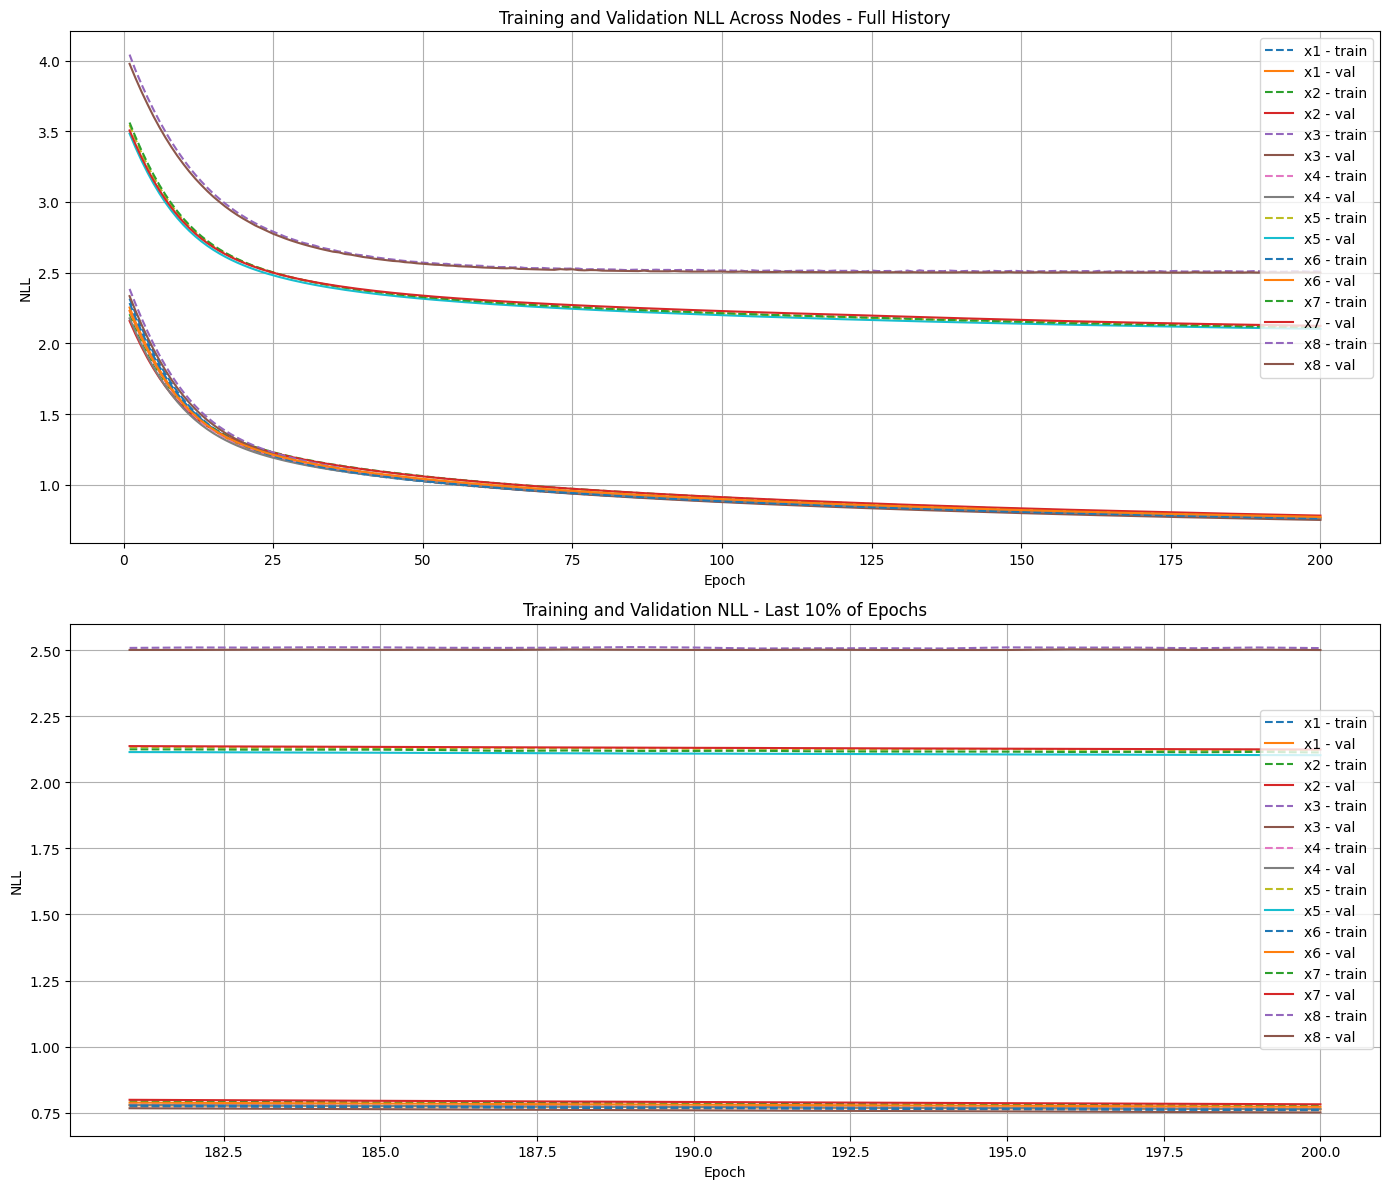

In [13]:
show_training_history(target_nodes,EXPERIMENT_DIR)

## 6.2 inspect transformation function for source nodes h()


----*----------*-------------*--------Inspect TRAFO Node: x1 ------------*-----------------*-------------------*--


h() for  x1:   0%|          | 0/1000 [00:00<?, ?it/s]


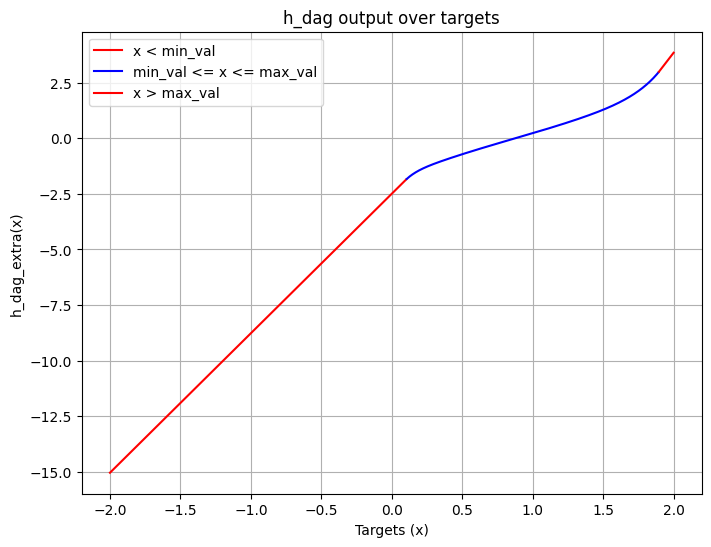


----*----------*-------------*--------Inspect TRAFO Node: x2 ------------*-----------------*-------------------*--


h() for  x2:   0%|          | 0/1000 [00:00<?, ?it/s]


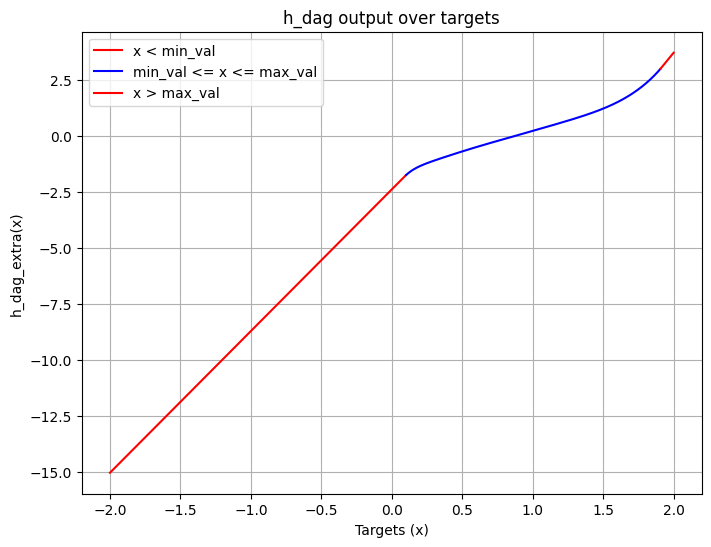


----*----------*-------------*--------Inspect TRAFO Node: x3 ------------*-----------------*-------------------*--


h() for  x3:   0%|          | 0/1000 [00:00<?, ?it/s]


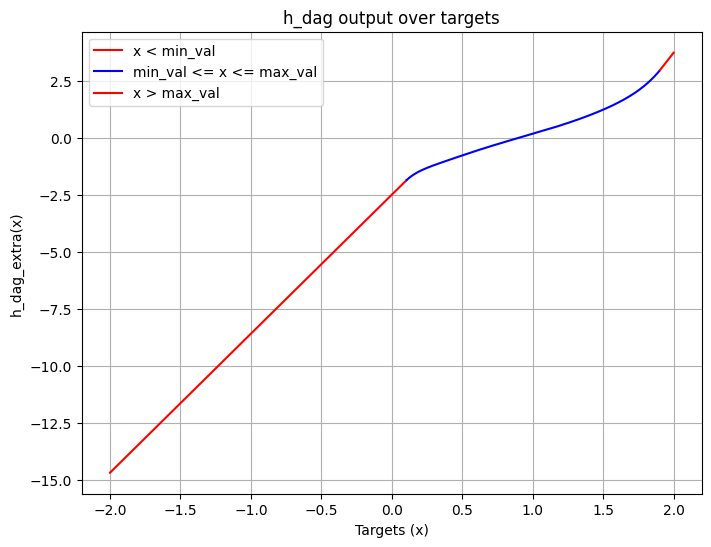


----*----------*-------------*--------Inspect TRAFO Node: x4 ------------*-----------------*-------------------*--


h() for  x4:   0%|          | 0/1000 [00:00<?, ?it/s]


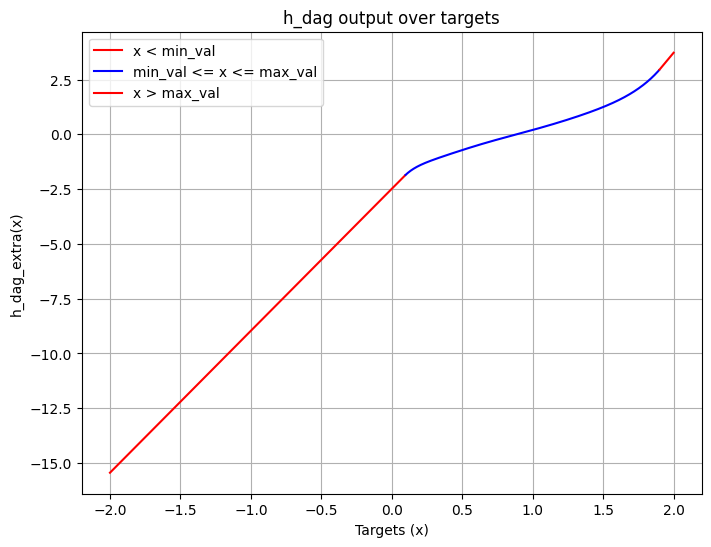


----*----------*-------------*--------Inspect TRAFO Node: x5 ------------*-----------------*-------------------*--


h() for  x5:   0%|          | 0/1000 [00:00<?, ?it/s]


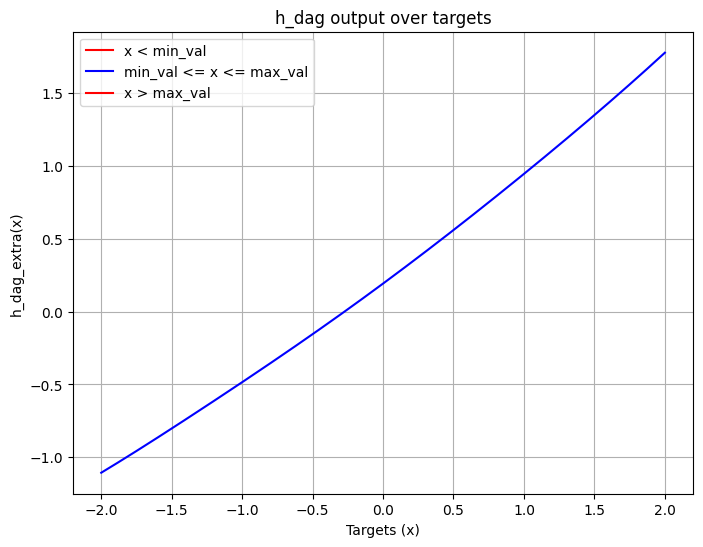


----*----------*-------------*--------Inspect TRAFO Node: x6 ------------*-----------------*-------------------*--


h() for  x6:   0%|          | 0/1000 [00:00<?, ?it/s]


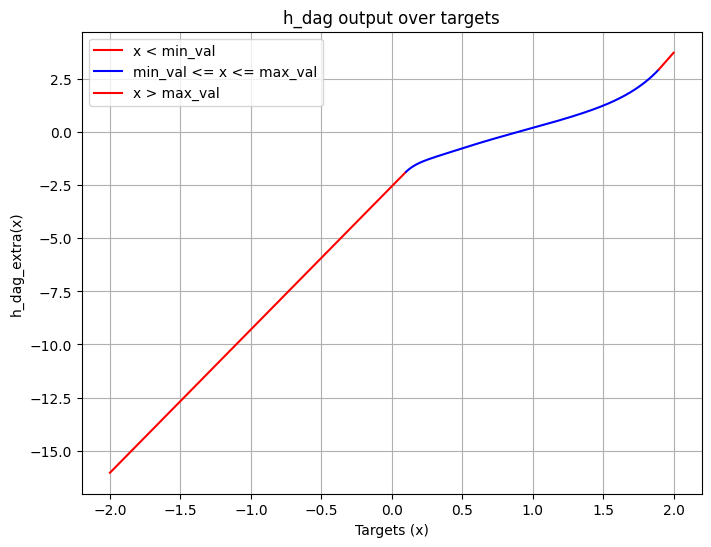


----*----------*-------------*--------Inspect TRAFO Node: x7 ------------*-----------------*-------------------*--


h() for  x7:   0%|          | 0/1000 [00:00<?, ?it/s]


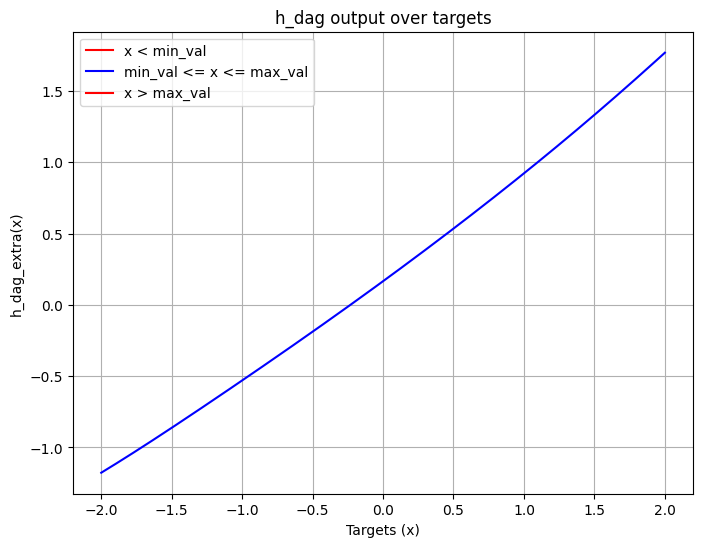


----*----------*-------------*--------Inspect TRAFO Node: x8 ------------*-----------------*-------------------*--
skipped.. since h does depend on parents and is different for every instance


In [14]:
show_hdag_for_source_nodes(target_nodes,EXPERIMENT_DIR,device=device,xmin_plot=-2,xmax_plot=2) # TODO for other nodes funciton


----*----------*-------------*--------h(data) should be standard logistic: x1 ------------*-----------------*-------------------*--


Val loader (x1): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


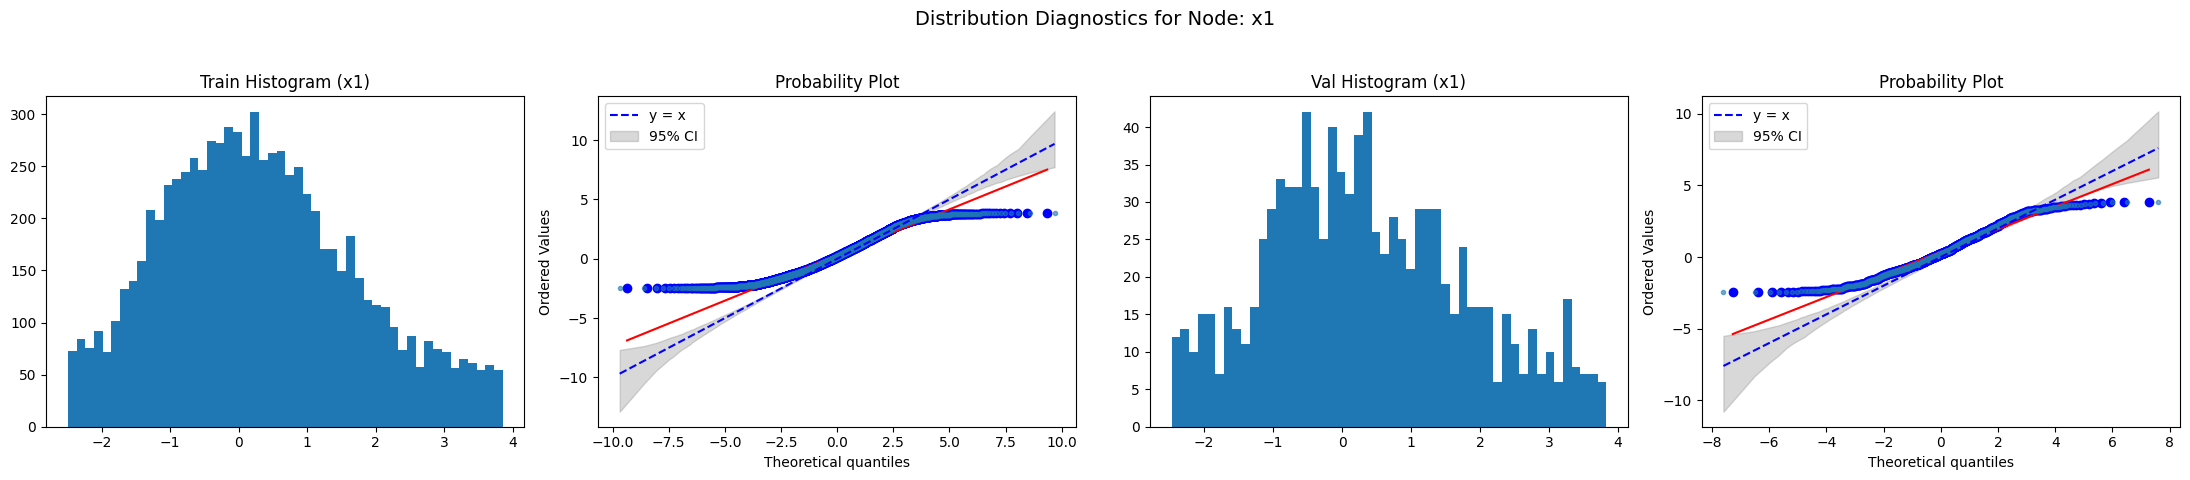


----*----------*-------------*--------h(data) should be standard logistic: x2 ------------*-----------------*-------------------*--


Val loader (x2): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


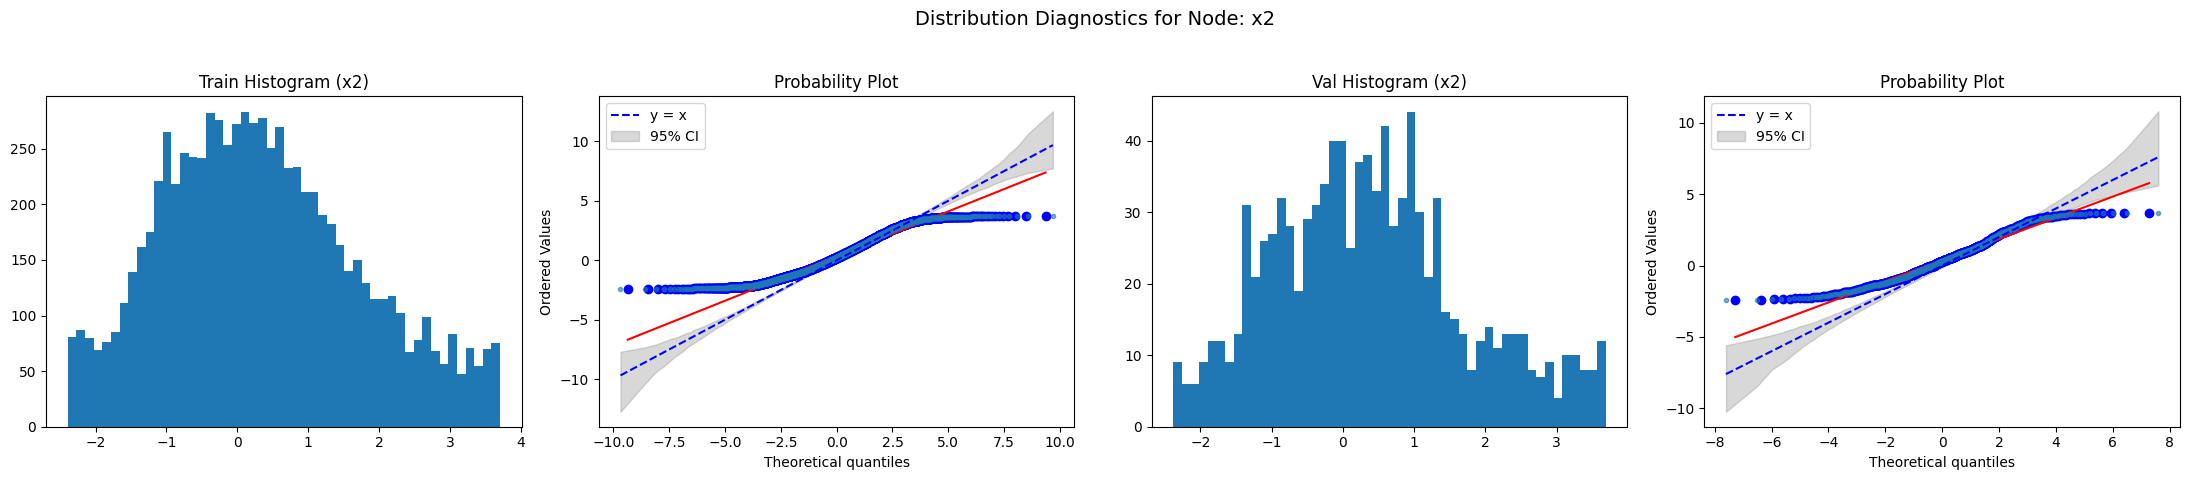


----*----------*-------------*--------h(data) should be standard logistic: x3 ------------*-----------------*-------------------*--


Val loader (x3): 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


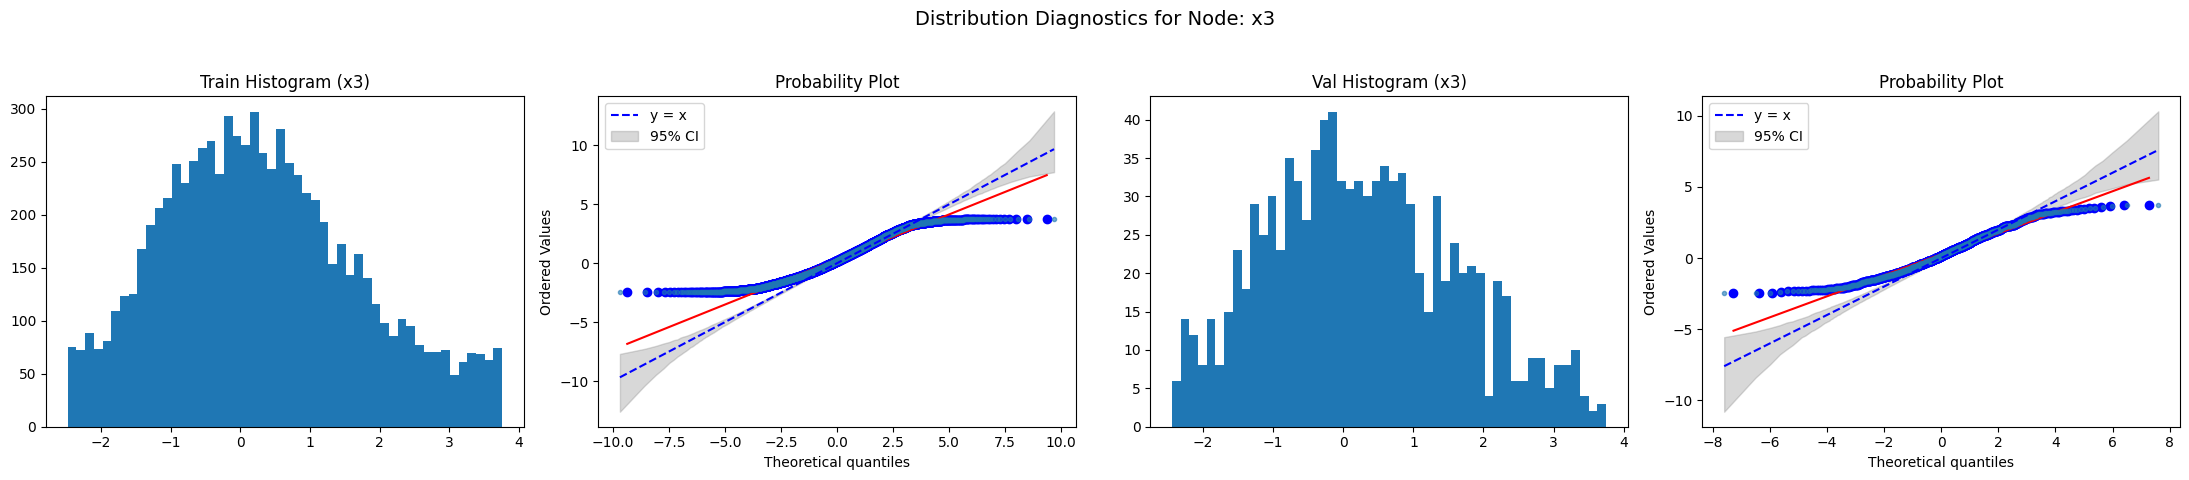


----*----------*-------------*--------h(data) should be standard logistic: x4 ------------*-----------------*-------------------*--


Val loader (x4): 100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


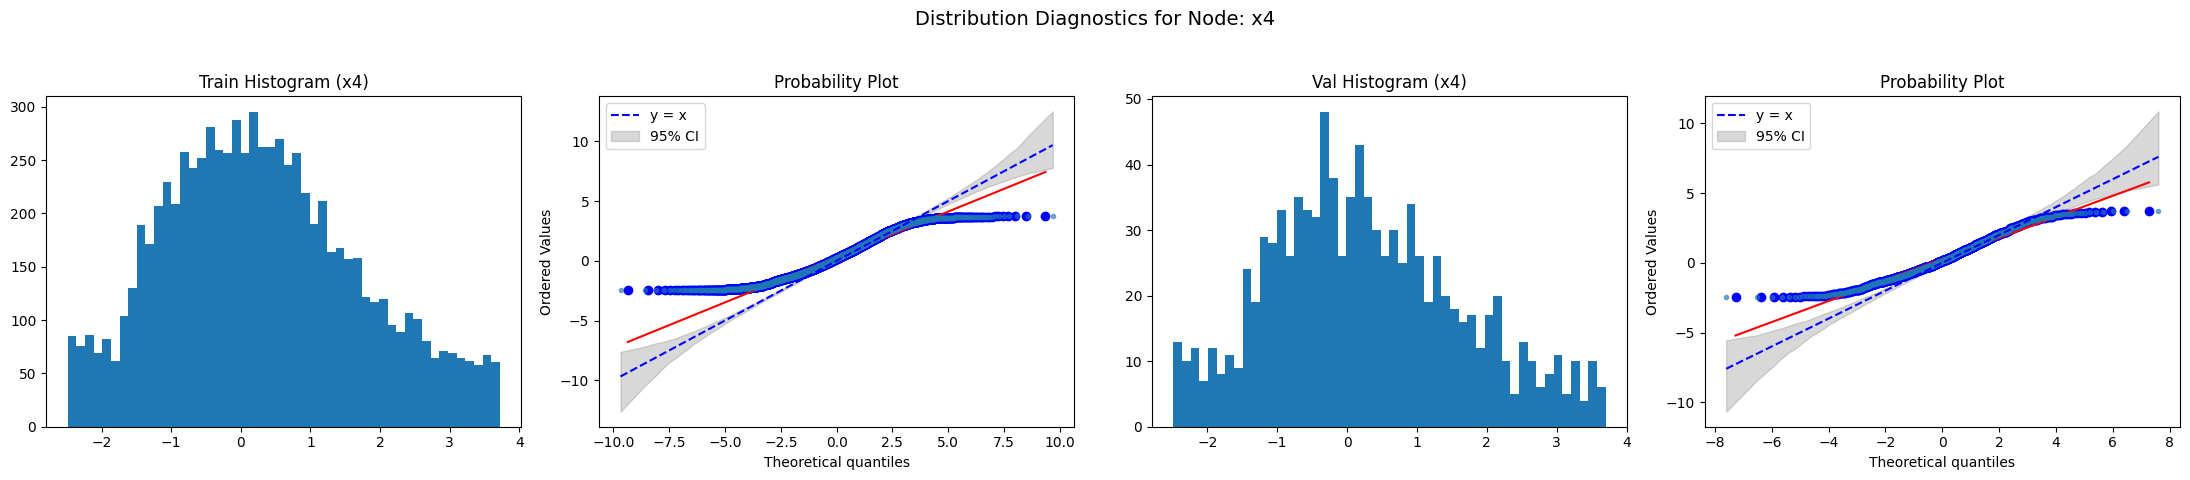


----*----------*-------------*--------h(data) should be standard logistic: x5 ------------*-----------------*-------------------*--


Val loader (x5): 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


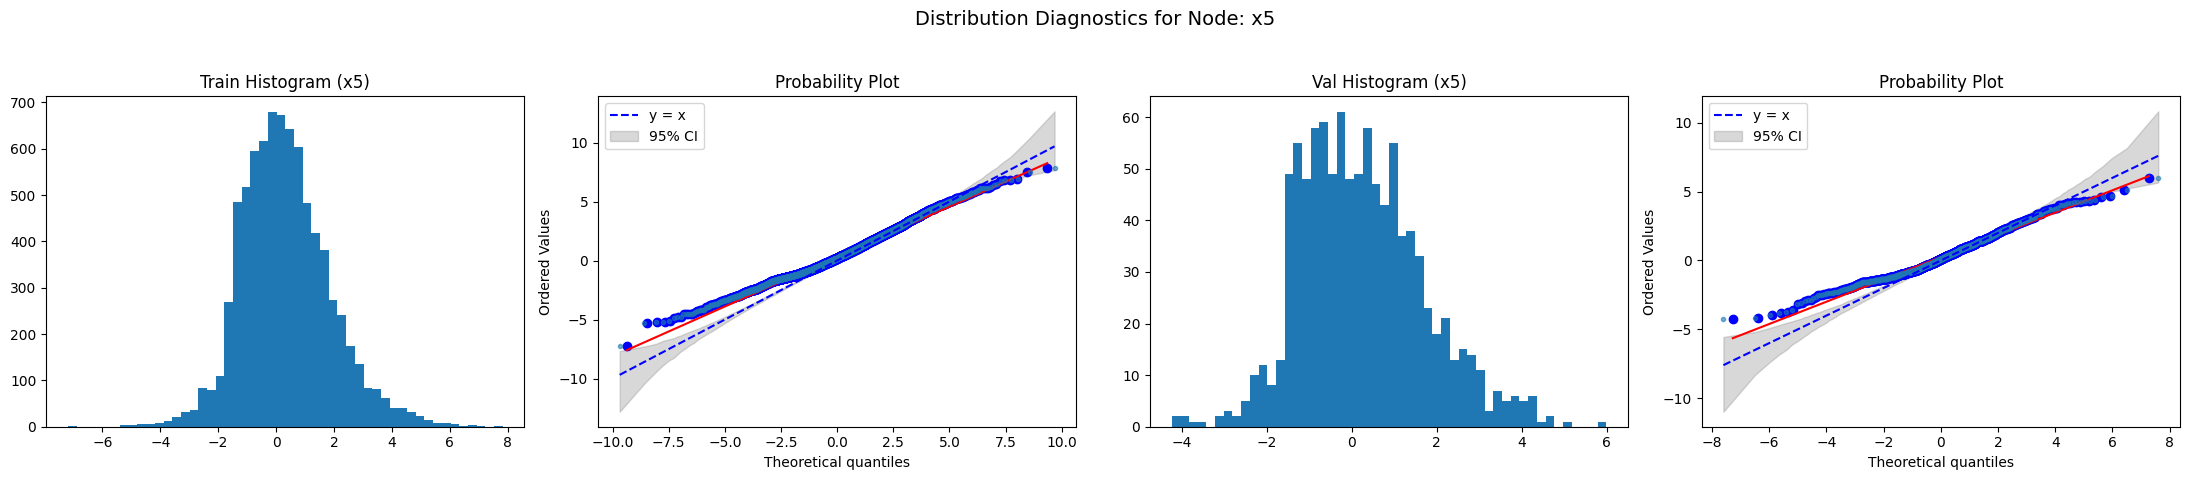


----*----------*-------------*--------h(data) should be standard logistic: x6 ------------*-----------------*-------------------*--


Val loader (x6): 100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


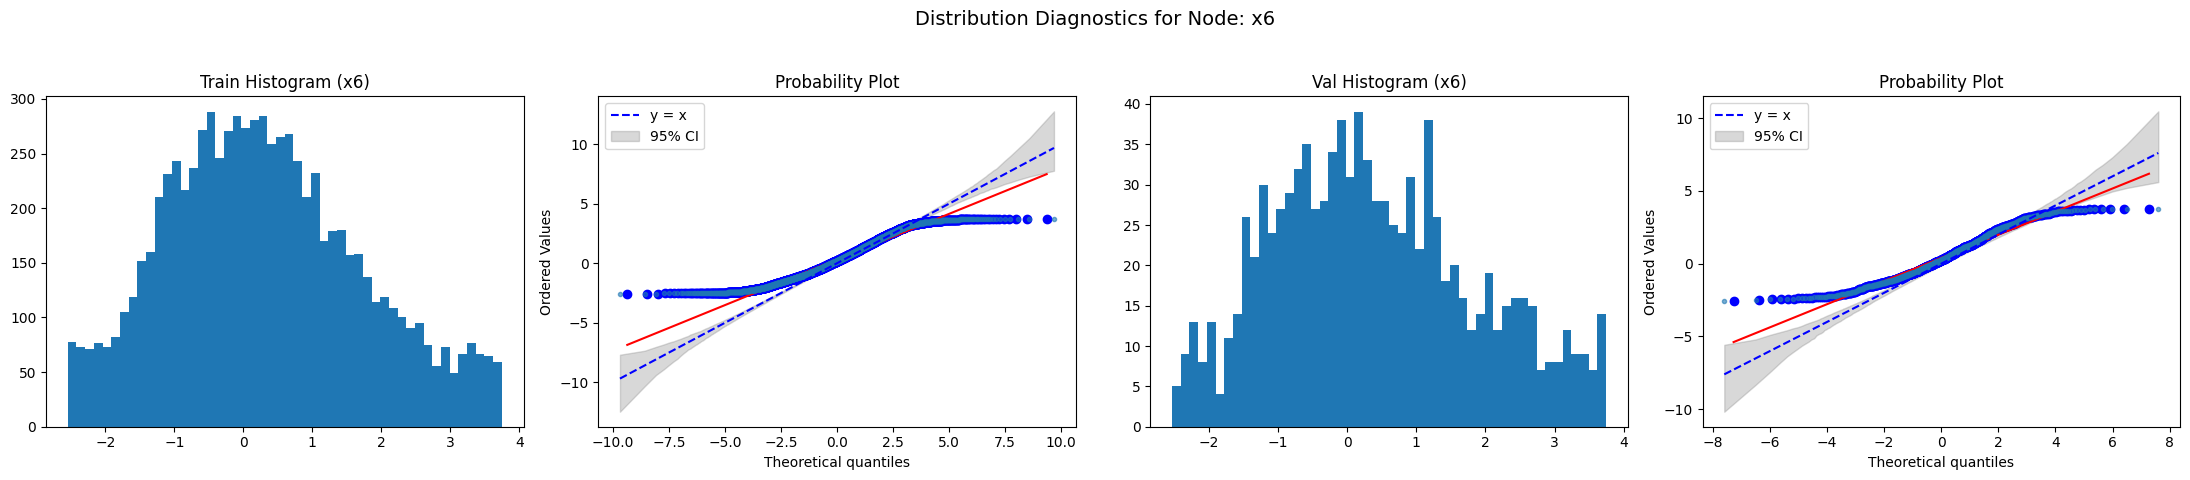


----*----------*-------------*--------h(data) should be standard logistic: x7 ------------*-----------------*-------------------*--


Val loader (x7): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


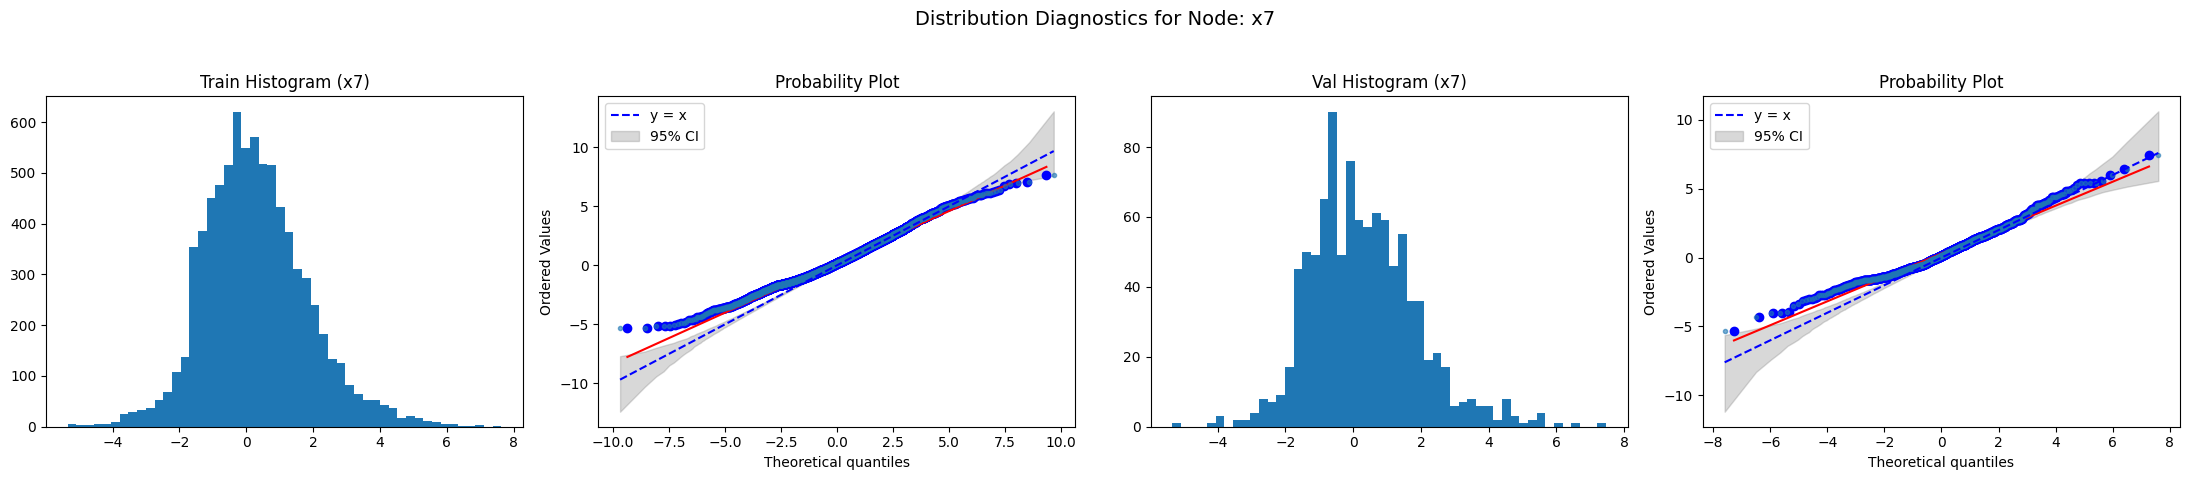


----*----------*-------------*--------h(data) should be standard logistic: x8 ------------*-----------------*-------------------*--


Val loader (x8): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


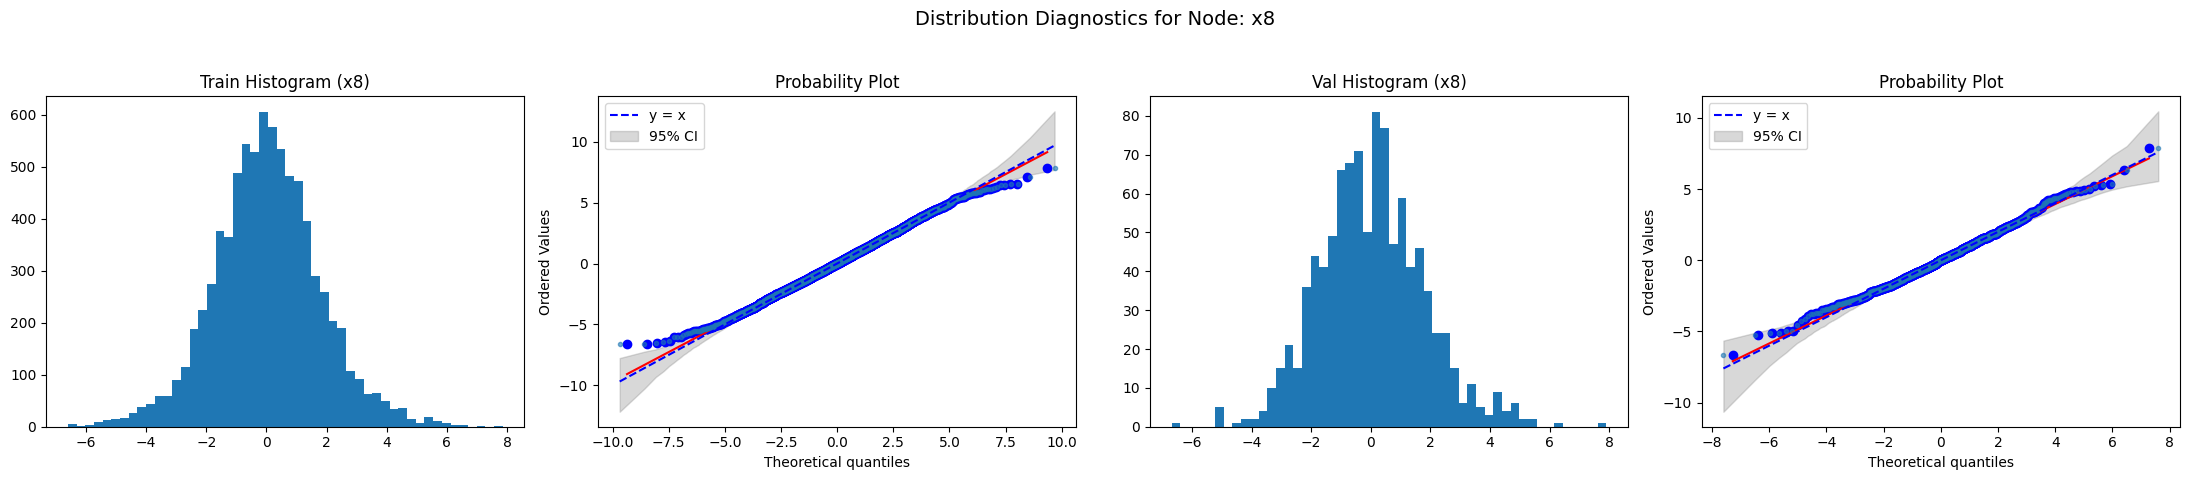

In [15]:
inspect_trafo_standart_logistic(target_nodes,EXPERIMENT_DIR,train_df,val_df,device,verbose=False)

### Coefficient estimates


---- check CS of x1 ----
Node type: source — skipping.

---- check CS of x2 ----
Node type: source — skipping.

---- check CS of x3 ----
Node type: source — skipping.

---- check CS of x4 ----
Node type: source — skipping.

---- check CS of x5 ----
Node type: source — skipping.

---- check CS of x6 ----
Node type: source — skipping.

---- check CS of x7 ----
Node type: source — skipping.

---- check CS of x8 ----

Module 0: ComplexShiftDefaultTabular
ComplexShiftDefaultTabular(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=1, bias=False)
)
  expects input shape = (batch_size, 1)


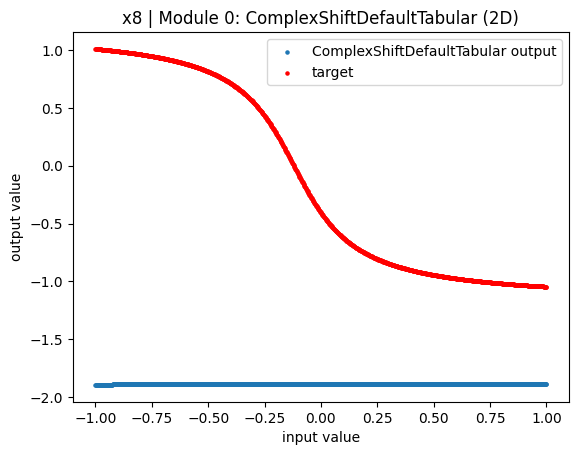

In [16]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # enable 3D plotting

# --- Your existing setup ---
verbose    = False
batch_size = 4112
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# this x is only for overlaying your target curve in 2D plots
x1d = torch.linspace(-1, 1, steps=1000).unsqueeze(1).to(device)  # (1000, 1)
def f(x):
    return 0.75 * np.arctan(5 * (x + 0.12))

for node in target_nodes:
    print(f"\n---- check CS of {node} ----")
    if target_nodes[node]['node_type'] == 'source':
        print("Node type: source — skipping.")
        continue

    # load your model
    NODE_DIR   = os.path.join(EXPERIMENT_DIR, node)
    model_path = os.path.join(NODE_DIR, "best_model.pt")
    tram_model = get_fully_specified_tram_model(node, target_nodes, verbose=verbose).to(device)
    tram_model.load_state_dict(torch.load(model_path))
    tram_model.eval()


    for i, module in enumerate(tram_model.nn_shift):
        name = module.__class__.__name__
        print(f"\nModule {i}: {name}")
        print(module)

        if name == 'LinearShift':
            print("  LinearShift weights:")
            print(module.fc.weight.data)
            continue

        # read wanted input dims
        in_feats = module.fc1.in_features
        print(f"  expects input shape = (batch_size, {in_feats})")

        # 2-input case → 3D surface plot
        if in_feats == 2:
            N = 100
            a = torch.linspace(-0, 2, steps=N, device=device)
            b = torch.linspace(-0, 2, steps=N, device=device)
            A, B = torch.meshgrid(a, b, indexing='ij')       # both (N, N)
            grid = torch.stack([A, B], dim=-1).view(-1, 2)   # (N*N, 2)

            with torch.no_grad():
                Y = module(grid).view(N, N).cpu().numpy()    # back to (N, N)

            A_np = A.cpu().numpy()
            B_np = B.cpu().numpy()

            fig = plt.figure()
            ax  = fig.add_subplot(111, projection='3d')
            ax.plot_surface(A_np, B_np, Y, cmap='viridis', edgecolor='none')
            ax.set_xlabel('input 1')
            ax.set_ylabel('input 2')
            ax.set_zlabel(f'{name}(x₁, x₂)')
            ax.set_title(f"{node} | Module {i}: {name} (3D surface)")
            plt.show()

        # 1-input case → 2D scatter
        else:
            N = 1000
            lin = torch.linspace(-1, 1, steps=N, device=device)
            dummy = lin.unsqueeze(1).repeat(1, in_feats)      # (N, in_feats)

            with torch.no_grad():
                y = module(dummy).squeeze().cpu().numpy()

            plt.figure()
            plt.scatter(dummy[:, 0].cpu().numpy(), y, s=5, label=f"{name} output")
            # overlay target
            plt.scatter(x1d.cpu().numpy(), -f(x1d.cpu().numpy()), c="red", s=5, label="target")
            plt.xlabel("input value")
            plt.ylabel("output value")
            plt.title(f"{node} | Module {i}: {name} (2D)")
            plt.legend()
            plt.show()


# 7. Sample from Graph

In [17]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            n= 10_000,
                            batch_size = 1,
                            delete_all_previously_sampled=False,
                            verbose=True)     


----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x1/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x1: 100%|██████████| 10000/10000 [00:01<00:00, 5724.03it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 330.92it/s]



----*----------*-------------*--------Sample Node: x2 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x2/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x2: 100%|██████████| 10000/10000 [00:01<00:00, 5884.18it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:29<00:00, 336.31it/s]



----*----------*-------------*--------Sample Node: x3 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x3/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x3: 100%|██████████| 10000/10000 [00:01<00:00, 5843.67it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 319.51it/s]



----*----------*-------------*--------Sample Node: x4 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x4/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x4: 100%|██████████| 10000/10000 [00:01<00:00, 5041.67it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:31<00:00, 322.46it/s]



----*----------*-------------*--------Sample Node: x5 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x5/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x5: 100%|██████████| 10000/10000 [00:01<00:00, 5740.96it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 327.06it/s]



----*----------*-------------*--------Sample Node: x6 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x6/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x6: 100%|██████████| 10000/10000 [00:01<00:00, 5720.34it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 332.87it/s]



----*----------*-------------*--------Sample Node: x7 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x7/sampling
-- sampled latents
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
-- loaded modelweights


h() for samples in  x7: 100%|██████████| 10000/10000 [00:01<00:00, 5650.19it/s]


source node, Defaults to SI and 1 as inputs


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 323.97it/s]
/home/bule/TramDag/utils/sampling_tram_data.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_list.append(torch.tensor(tensor))  # ensure tensor type



----*----------*-------------*--------Sample Node: x8 ------------*-----------------*-------------------*--
Root or latent files not found in /home/bule/TramDag/dev_experiment_logs/conf_dict/x8/sampling
-- sampled latents
>>>>>>>>>>>> No ci detected --> intercept defaults to si
>>> TRAM MODEL:
 TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
  (nn_shift): ModuleList(
    (0): ComplexShiftDefaultTabular(
      (fc1): Linear(in_features=1, out_features=64, bias=True)
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (fc2): Linear(in_features=64, out_features=128, bias=True)
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (fc3): Linear(in_features=128, out_features=64, bias=True)
      (relu3): ReLU()
      (dropout3): Dropout(p=0.3, inplace=False)
      (fc4): Linear(in_features=64, out_features=1, bias=False)
    )
  )
)
-- loaded modelweights


h() for samples in  x8: 100%|██████████| 10000/10000 [00:06<00:00, 1508.65it/s]


node has parents, previously sampled data is loaded for each pa(node)


Chandrupatla root finding: 100%|██████████| 10000/10000 [00:30<00:00, 328.11it/s]


## 7.3 Inspect Sampling

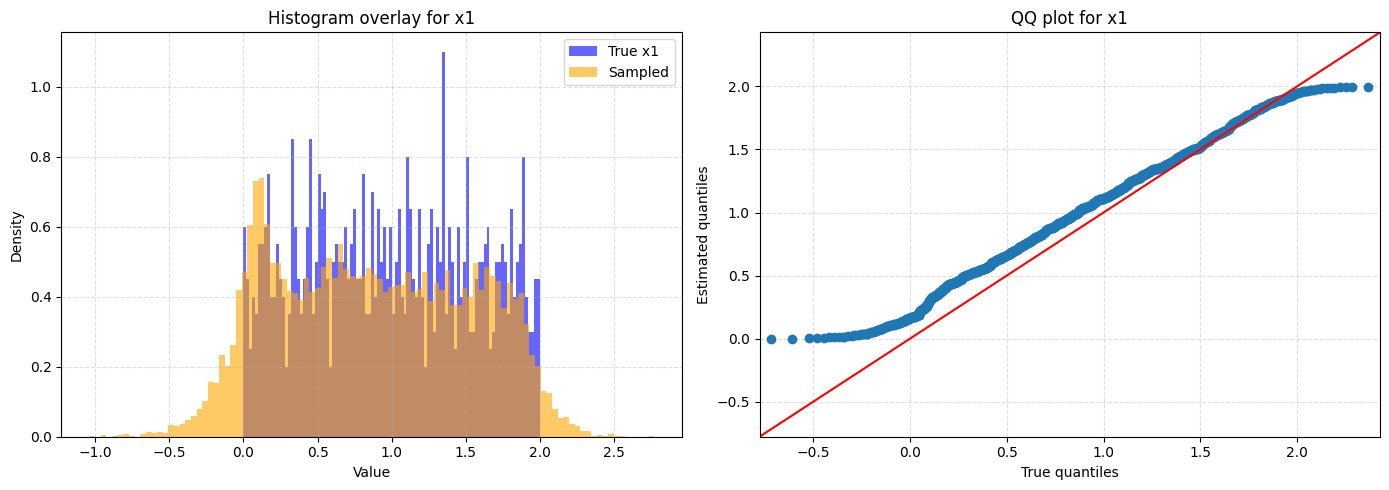

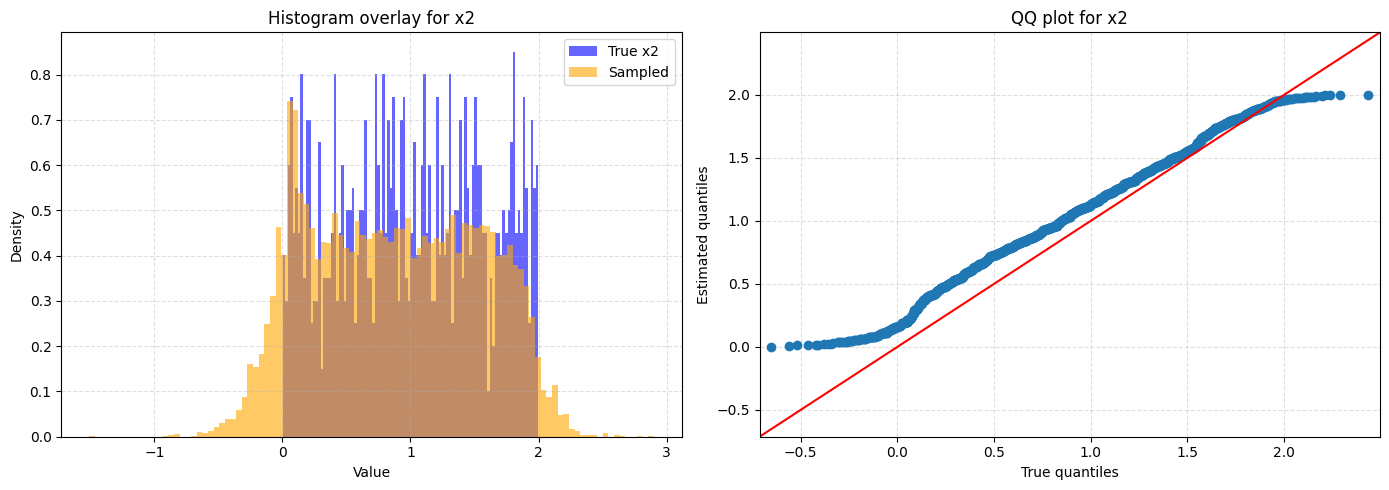

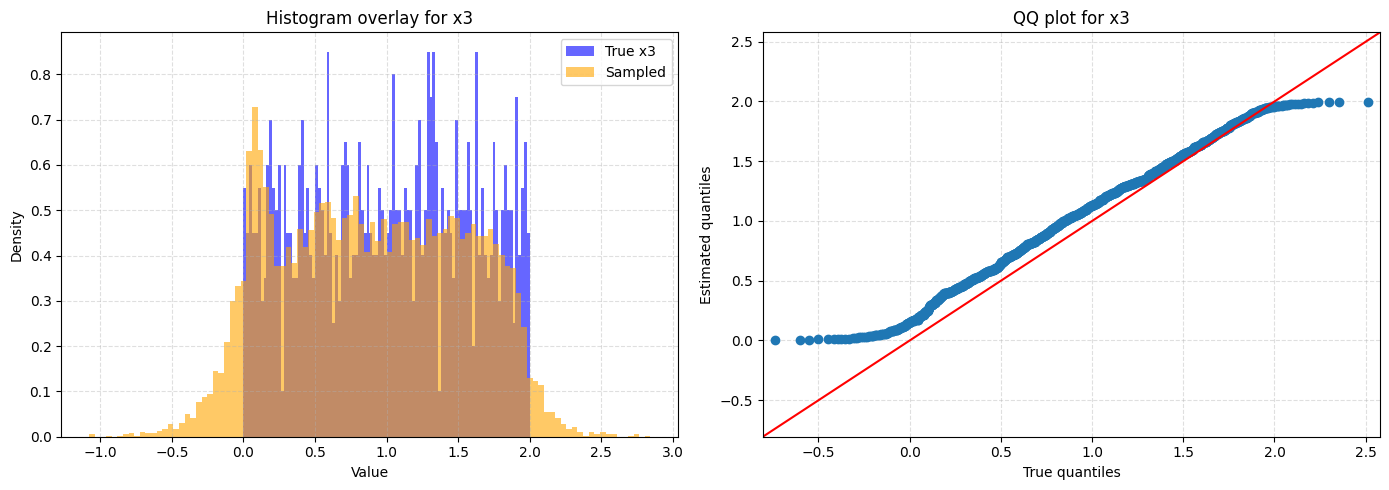

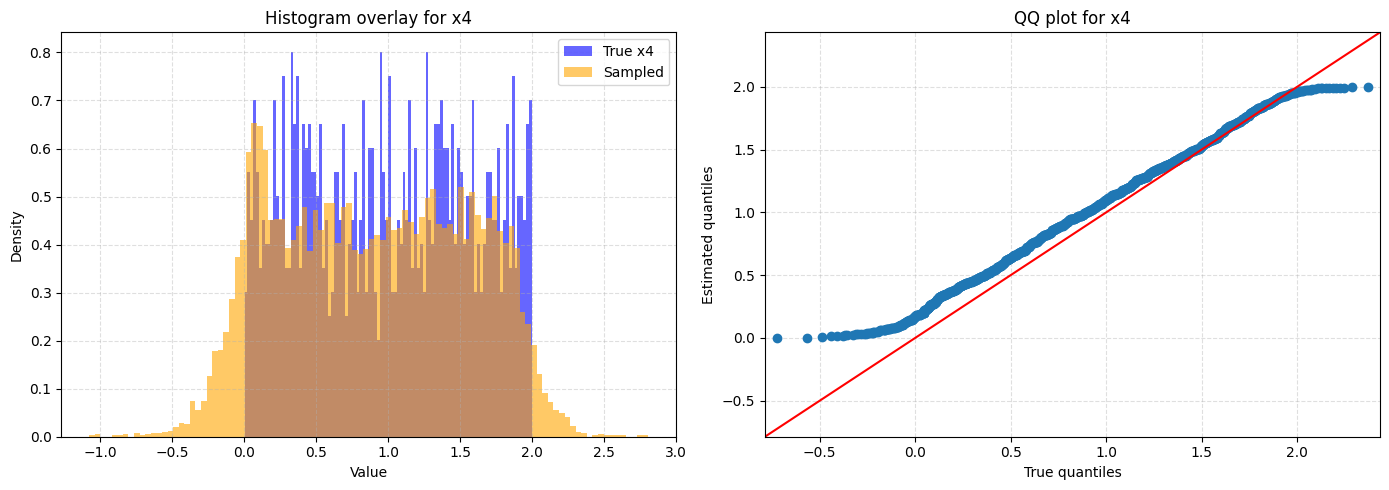

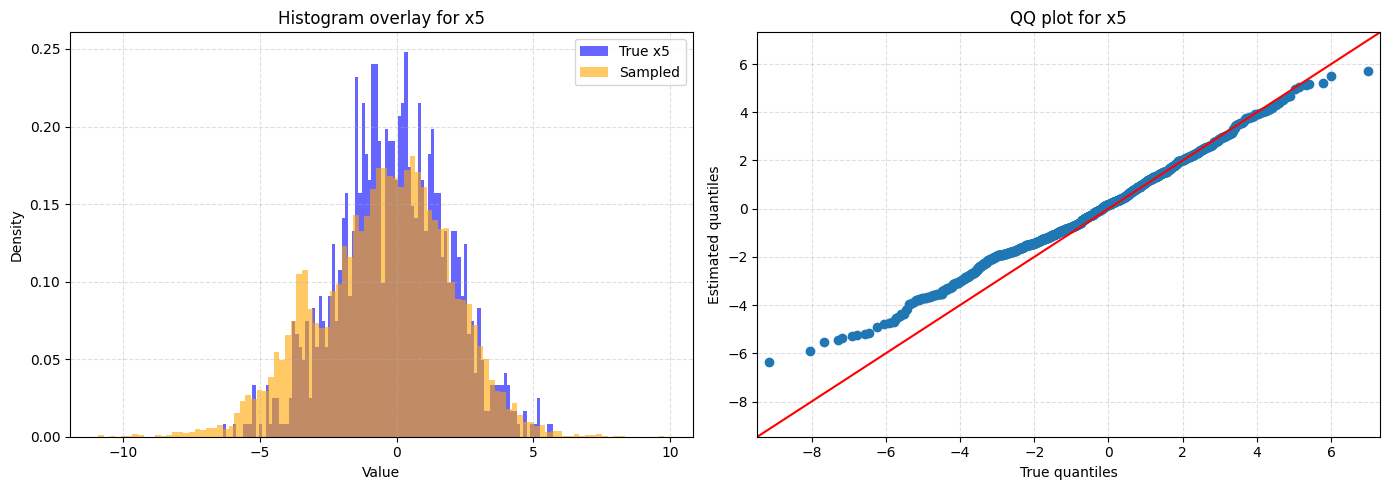

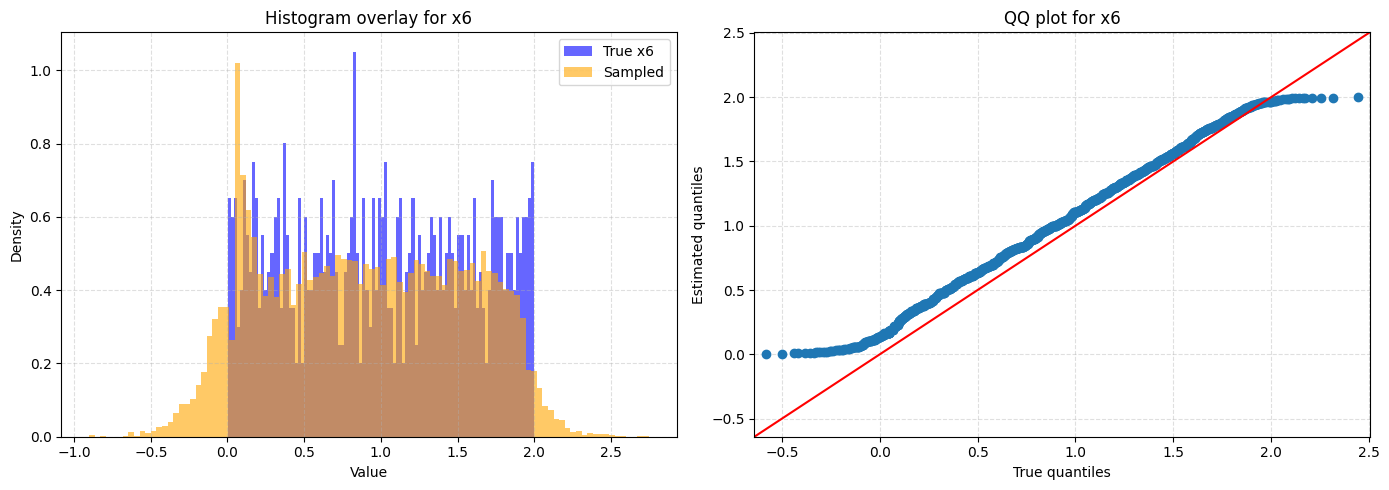

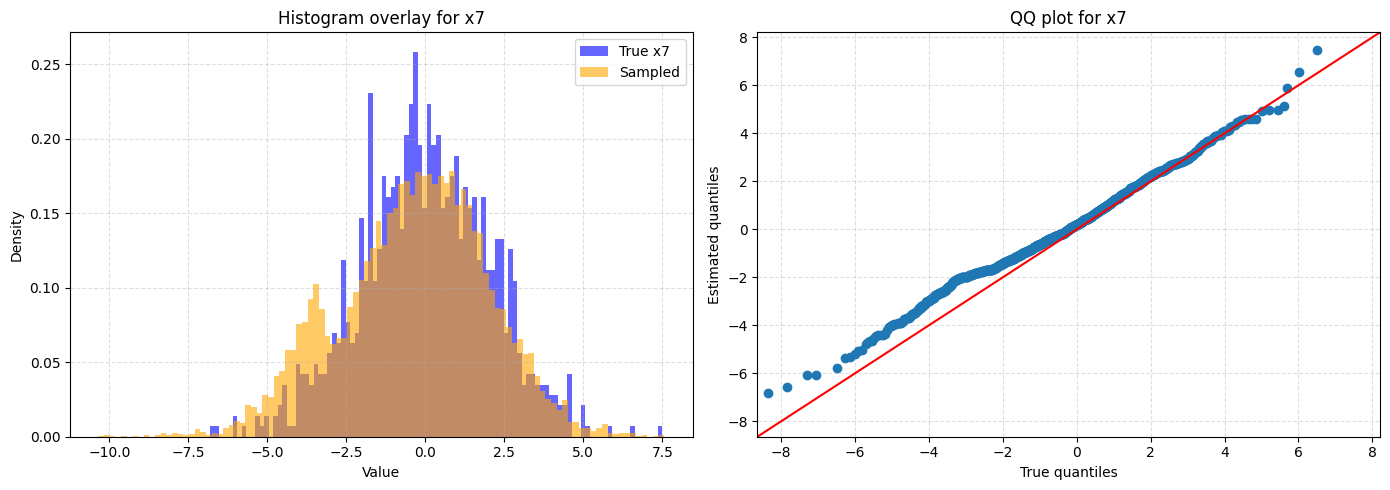

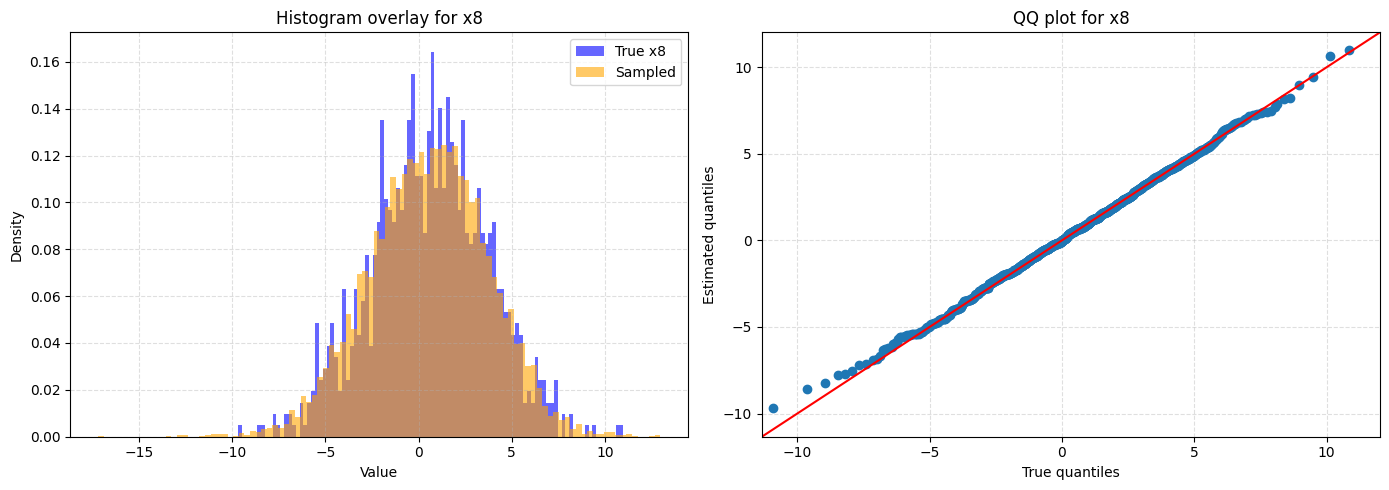

In [18]:
show_samples_vs_true(test_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')

## 7.4 Intervention

In [19]:
def f(x):
    return -0.3*x  

intervention_df=dgp(10_000, doX=[-1.0, None, None], seed=-1)
sns.pairplot(intervention_df)
plt.suptitle("", y=1.02)
plt.tight_layout()
plt.show()

NameError: name 'dgp' is not defined

In [ ]:
sample_full_dag_chandru(target_nodes,
                            EXPERIMENT_DIR,
                            device,
                            do_interventions={'x1':-1.0},
                            n= 10_000,
                            batch_size = 32,
                            delete_all_previously_sampled=True,
                            verbose=True)

In [ ]:
show_samples_vs_true(intervention_df,target_nodes,EXPERIMENT_DIR,rootfinder='chandrupatla')